##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) and [predicting fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression) — we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

In other words, our model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what we really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [4]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 23s

     16384/2816407858 [..............................] - ETA: 6:26:37

     49152/2816407858 [..............................] - ETA: 4:19:26

     90112/2816407858 [..............................] - ETA: 3:38:10

    188416/2816407858 [..............................] - ETA: 2:17:26

    311296/2816407858 [..............................] - ETA: 1:42:36

    417792/2816407858 [..............................] - ETA: 1:30:53

    671744/2816407858 [..............................] - ETA: 1:05:31

   1187840/2816407858 [..............................] - ETA: 42:07  

   2220032/2816407858 [..............................] - ETA: 25:15

   3448832/2816407858 [..............................] - ETA: 21:28

   3989504/2816407858 [..............................] - ETA: 20:17

   6209536/2816407858 [..............................] - ETA: 13:51

   7462912/2816407858 [..............................] - ETA: 12:20

   8732672/2816407858 [..............................] - ETA: 11:14

  10027008/2816407858 [..............................] - ETA: 10:22

  11345920/2816407858 [..............................] - ETA: 9:42 

  12673024/2816407858 [..............................] - ETA: 9:09

  14032896/2816407858 [..............................] - ETA: 9:07

  16359424/2816407858 [..............................] - ETA: 8:11

  17326080/2816407858 [..............................] - ETA: 7:57

  17580032/2816407858 [..............................] - ETA: 7:58

  18259968/2816407858 [..............................] - ETA: 8:39

  18743296/2816407858 [..............................] - ETA: 8:45

  19701760/2816407858 [..............................] - ETA: 8:37

  20692992/2816407858 [..............................] - ETA: 8:30

  21692416/2816407858 [..............................] - ETA: 8:22

  22675456/2816407858 [..............................] - ETA: 8:08

  22716416/2816407858 [..............................] - ETA: 8:15

  23699456/2816407858 [..............................] - ETA: 8:02

  23732224/2816407858 [..............................] - ETA: 8:09

  24739840/2816407858 [..............................] - ETA: 7:56

  24764416/2816407858 [..............................] - ETA: 8:03

  25788416/2816407858 [..............................] - ETA: 7:51

  25796608/2816407858 [..............................] - ETA: 7:57

  26828800/2816407858 [..............................] - ETA: 7:45

  26853376/2816407858 [..............................] - ETA: 7:52

  27885568/2816407858 [..............................] - ETA: 7:40

  27910144/2816407858 [..............................] - ETA: 7:47

  28950528/2816407858 [..............................] - ETA: 7:35

  28975104/2816407858 [..............................] - ETA: 7:42

  30023680/2816407858 [..............................] - ETA: 7:31

  30040064/2816407858 [..............................] - ETA: 7:37

  31105024/2816407858 [..............................] - ETA: 7:26

  31113216/2816407858 [..............................] - ETA: 7:33

  32186368/2816407858 [..............................] - ETA: 7:22

  32202752/2816407858 [..............................] - ETA: 7:28

  32858112/2816407858 [..............................] - ETA: 7:31

  34144256/2816407858 [..............................] - ETA: 7:24

  34390016/2816407858 [..............................] - ETA: 7:31

  35135488/2816407858 [..............................] - ETA: 7:31

  35905536/2816407858 [..............................] - ETA: 7:32

  36691968/2816407858 [..............................] - ETA: 7:32

  37486592/2816407858 [..............................] - ETA: 7:32

  38297600/2816407858 [..............................] - ETA: 7:31

  39108608/2816407858 [..............................] - ETA: 7:31

  39927808/2816407858 [..............................] - ETA: 7:30

  40755200/2816407858 [..............................] - ETA: 7:30

  41598976/2816407858 [..............................] - ETA: 7:29

  42442752/2816407858 [..............................] - ETA: 7:26

  43294720/2816407858 [..............................] - ETA: 7:28

  44154880/2816407858 [..............................] - ETA: 7:27

  45023232/2816407858 [..............................] - ETA: 7:26

  45891584/2816407858 [..............................] - ETA: 7:25

  46768128/2816407858 [..............................] - ETA: 7:25

  47636480/2816407858 [..............................] - ETA: 7:24

  48521216/2816407858 [..............................] - ETA: 7:23

  49414144/2816407858 [..............................] - ETA: 7:22

  50307072/2816407858 [..............................] - ETA: 7:21

  51200000/2816407858 [..............................] - ETA: 7:20

  52101120/2816407858 [..............................] - ETA: 7:19

  53002240/2816407858 [..............................] - ETA: 7:19

  53903360/2816407858 [..............................] - ETA: 7:18

  54812672/2816407858 [..............................] - ETA: 7:17

  55721984/2816407858 [..............................] - ETA: 7:16

  56639488/2816407858 [..............................] - ETA: 7:18

  57556992/2816407858 [..............................] - ETA: 7:14

  58466304/2816407858 [..............................] - ETA: 7:13

  59383808/2816407858 [..............................] - ETA: 7:12

  60301312/2816407858 [..............................] - ETA: 7:10

  60325888/2816407858 [..............................] - ETA: 7:13

  61227008/2816407858 [..............................] - ETA: 7:11

  62144512/2816407858 [..............................] - ETA: 7:10

  63053824/2816407858 [..............................] - ETA: 7:06

  63070208/2816407858 [..............................] - ETA: 7:09

  63938560/2816407858 [..............................] - ETA: 7:05

  63987712/2816407858 [..............................] - ETA: 7:08

  64831488/2816407858 [..............................] - ETA: 7:05

  64913408/2816407858 [..............................] - ETA: 7:07

  65765376/2816407858 [..............................] - ETA: 7:04

  65839104/2816407858 [..............................] - ETA: 7:07

  66691072/2816407858 [..............................] - ETA: 7:03

  66764800/2816407858 [..............................] - ETA: 7:06

  67616768/2816407858 [..............................] - ETA: 7:02

  67690496/2816407858 [..............................] - ETA: 7:05

  68558848/2816407858 [..............................] - ETA: 7:02

  68624384/2816407858 [..............................] - ETA: 7:04

  69312512/2816407858 [..............................] - ETA: 7:02

  69476352/2816407858 [..............................] - ETA: 7:06

  70443008/2816407858 [..............................] - ETA: 7:03

  70926336/2816407858 [..............................] - ETA: 7:02

  71098368/2816407858 [..............................] - ETA: 7:04

  71581696/2816407858 [..............................] - ETA: 7:03

  71761920/2816407858 [..............................] - ETA: 7:05

  72261632/2816407858 [..............................] - ETA: 7:04

  72441856/2816407858 [..............................] - ETA: 7:07

  73113600/2816407858 [..............................] - ETA: 7:05

  73129984/2816407858 [..............................] - ETA: 7:08

  73809920/2816407858 [..............................] - ETA: 7:06

  73826304/2816407858 [..............................] - ETA: 7:09

  74522624/2816407858 [..............................] - ETA: 7:07

  74547200/2816407858 [..............................] - ETA: 7:09

  75251712/2816407858 [..............................] - ETA: 7:07

  75268096/2816407858 [..............................] - ETA: 7:10

  75980800/2816407858 [..............................] - ETA: 7:07

  76005376/2816407858 [..............................] - ETA: 7:10

  76734464/2816407858 [..............................] - ETA: 7:08

  76759040/2816407858 [..............................] - ETA: 7:10

  77488128/2816407858 [..............................] - ETA: 7:08

  77512704/2816407858 [..............................] - ETA: 7:10

  78258176/2816407858 [..............................] - ETA: 7:08

  78282752/2816407858 [..............................] - ETA: 7:11

  79028224/2816407858 [..............................] - ETA: 7:08

  79060992/2816407858 [..............................] - ETA: 7:11

  79814656/2816407858 [..............................] - ETA: 7:08

  79847424/2816407858 [..............................] - ETA: 7:11

  80617472/2816407858 [..............................] - ETA: 7:08

  80633856/2816407858 [..............................] - ETA: 7:11

  81420288/2816407858 [..............................] - ETA: 7:08

  81444864/2816407858 [..............................] - ETA: 7:11

  82231296/2816407858 [..............................] - ETA: 7:08

  82255872/2816407858 [..............................] - ETA: 7:11

  83042304/2816407858 [..............................] - ETA: 7:08

  83075072/2816407858 [..............................] - ETA: 7:11

  83861504/2816407858 [..............................] - ETA: 7:08

  83902464/2816407858 [..............................] - ETA: 7:10

  84697088/2816407858 [..............................] - ETA: 7:08

  84738048/2816407858 [..............................] - ETA: 7:10

  85540864/2816407858 [..............................] - ETA: 7:08

  85573632/2816407858 [..............................] - ETA: 7:10

  86384640/2816407858 [..............................] - ETA: 7:08

  86425600/2816407858 [..............................] - ETA: 7:10

  87236608/2816407858 [..............................] - ETA: 7:07

  87277568/2816407858 [..............................] - ETA: 7:09

  88096768/2816407858 [..............................] - ETA: 7:07

  88129536/2816407858 [..............................] - ETA: 7:09

  88956928/2816407858 [..............................] - ETA: 7:07

  88989696/2816407858 [..............................] - ETA: 7:09

  89833472/2816407858 [..............................] - ETA: 7:06

  89858048/2816407858 [..............................] - ETA: 7:08

  90693632/2816407858 [..............................] - ETA: 7:06

  90734592/2816407858 [..............................] - ETA: 7:08

  91578368/2816407858 [..............................] - ETA: 7:05

  91611136/2816407858 [..............................] - ETA: 7:08

  92454912/2816407858 [..............................] - ETA: 7:05

  92495872/2816407858 [..............................] - ETA: 7:07

  93347840/2816407858 [..............................] - ETA: 7:05

  93388800/2816407858 [..............................] - ETA: 7:07

  94232576/2816407858 [>.............................] - ETA: 7:04

  94281728/2816407858 [>.............................] - ETA: 7:06

  95125504/2816407858 [>.............................] - ETA: 7:04

  95174656/2816407858 [>.............................] - ETA: 7:06

  96018432/2816407858 [>.............................] - ETA: 7:03

  96067584/2816407858 [>.............................] - ETA: 7:05

  96919552/2816407858 [>.............................] - ETA: 7:03

  96960512/2816407858 [>.............................] - ETA: 7:05

  97820672/2816407858 [>.............................] - ETA: 7:02

  97869824/2816407858 [>.............................] - ETA: 7:04

  98729984/2816407858 [>.............................] - ETA: 7:02

  98779136/2816407858 [>.............................] - ETA: 7:04

  99631104/2816407858 [>.............................] - ETA: 7:01

  99680256/2816407858 [>.............................] - ETA: 7:03

 100548608/2816407858 [>.............................] - ETA: 7:01

 100589568/2816407858 [>.............................] - ETA: 7:03

 101457920/2816407858 [>.............................] - ETA: 7:00

 101490688/2816407858 [>.............................] - ETA: 7:02

 102367232/2816407858 [>.............................] - ETA: 7:00

 102400000/2816407858 [>.............................] - ETA: 7:02

 103284736/2816407858 [>.............................] - ETA: 6:59

 103325696/2816407858 [>.............................] - ETA: 7:01

 104210432/2816407858 [>.............................] - ETA: 6:59

 104243200/2816407858 [>.............................] - ETA: 7:01

 105127936/2816407858 [>.............................] - ETA: 6:58

 105160704/2816407858 [>.............................] - ETA: 7:00

 106045440/2816407858 [>.............................] - ETA: 6:58

 106086400/2816407858 [>.............................] - ETA: 7:00

 106962944/2816407858 [>.............................] - ETA: 6:58

 107003904/2816407858 [>.............................] - ETA: 6:59

 107888640/2816407858 [>.............................] - ETA: 6:57

 107929600/2816407858 [>.............................] - ETA: 6:59

 108806144/2816407858 [>.............................] - ETA: 6:57

 108855296/2816407858 [>.............................] - ETA: 6:58

 109723648/2816407858 [>.............................] - ETA: 6:56

 109764608/2816407858 [>.............................] - ETA: 6:58

 110641152/2816407858 [>.............................] - ETA: 6:56

 110690304/2816407858 [>.............................] - ETA: 6:57

 111566848/2816407858 [>.............................] - ETA: 6:55

 111624192/2816407858 [>.............................] - ETA: 6:57

 112484352/2816407858 [>.............................] - ETA: 6:55

 112549888/2816407858 [>.............................] - ETA: 6:56

 112615424/2816407858 [>.............................] - ETA: 6:59

 113524736/2816407858 [>.............................] - ETA: 6:58

 114442240/2816407858 [>.............................] - ETA: 6:58

 115376128/2816407858 [>.............................] - ETA: 6:57

 116310016/2816407858 [>.............................] - ETA: 6:57

 117235712/2816407858 [>.............................] - ETA: 6:56

 118169600/2816407858 [>.............................] - ETA: 6:56

 119103488/2816407858 [>.............................] - ETA: 6:55

 120029184/2816407858 [>.............................] - ETA: 6:55

 120963072/2816407858 [>.............................] - ETA: 6:54

 121888768/2816407858 [>.............................] - ETA: 6:54

 122822656/2816407858 [>.............................] - ETA: 6:54

 123756544/2816407858 [>.............................] - ETA: 6:53

 124690432/2816407858 [>.............................] - ETA: 6:53

 125607936/2816407858 [>.............................] - ETA: 6:52

 126541824/2816407858 [>.............................] - ETA: 6:52

 127467520/2816407858 [>.............................] - ETA: 6:51

 128401408/2816407858 [>.............................] - ETA: 6:51

 129327104/2816407858 [>.............................] - ETA: 6:50

 130260992/2816407858 [>.............................] - ETA: 6:50

 131194880/2816407858 [>.............................] - ETA: 6:50

 132128768/2816407858 [>.............................] - ETA: 6:49

 133054464/2816407858 [>.............................] - ETA: 6:49

 133988352/2816407858 [>.............................] - ETA: 6:48

 134922240/2816407858 [>.............................] - ETA: 6:48

 135856128/2816407858 [>.............................] - ETA: 6:48

 136790016/2816407858 [>.............................] - ETA: 6:47

 137715712/2816407858 [>.............................] - ETA: 6:47

 138649600/2816407858 [>.............................] - ETA: 6:46

 139583488/2816407858 [>.............................] - ETA: 6:46

 140517376/2816407858 [>.............................] - ETA: 6:46

 141443072/2816407858 [>.............................] - ETA: 6:45

 142376960/2816407858 [>.............................] - ETA: 6:45

 143319040/2816407858 [>.............................] - ETA: 6:44

 144252928/2816407858 [>.............................] - ETA: 6:43

 144293888/2816407858 [>.............................] - ETA: 6:44

 145203200/2816407858 [>.............................] - ETA: 6:44

 146145280/2816407858 [>.............................] - ETA: 6:42

 146169856/2816407858 [>.............................] - ETA: 6:43

 147103744/2816407858 [>.............................] - ETA: 6:43

 148045824/2816407858 [>.............................] - ETA: 6:42

 148054016/2816407858 [>.............................] - ETA: 6:42

 149004288/2816407858 [>.............................] - ETA: 6:42

 149970944/2816407858 [>.............................] - ETA: 6:42

 150929408/2816407858 [>.............................] - ETA: 6:41

 151896064/2816407858 [>.............................] - ETA: 6:41

 152862720/2816407858 [>.............................] - ETA: 6:40

 153837568/2816407858 [>.............................] - ETA: 6:40

 154812416/2816407858 [>.............................] - ETA: 6:39

 155795456/2816407858 [>.............................] - ETA: 6:39

 156778496/2816407858 [>.............................] - ETA: 6:38

 157761536/2816407858 [>.............................] - ETA: 6:37

 157769728/2816407858 [>.............................] - ETA: 6:38

 158760960/2816407858 [>.............................] - ETA: 6:38

 159760384/2816407858 [>.............................] - ETA: 6:37

 160768000/2816407858 [>.............................] - ETA: 6:37

 161193984/2816407858 [>.............................] - ETA: 6:38

 162611200/2816407858 [>.............................] - ETA: 6:36

 163323904/2816407858 [>.............................] - ETA: 6:35

 163340288/2816407858 [>.............................] - ETA: 6:36

 164052992/2816407858 [>.............................] - ETA: 6:36

 164077568/2816407858 [>.............................] - ETA: 6:36

 164798464/2816407858 [>.............................] - ETA: 6:36

 164823040/2816407858 [>.............................] - ETA: 6:37

 165552128/2816407858 [>.............................] - ETA: 6:36

 165576704/2816407858 [>.............................] - ETA: 6:37

 166330368/2816407858 [>.............................] - ETA: 6:36

 166346752/2816407858 [>.............................] - ETA: 6:37

 167108608/2816407858 [>.............................] - ETA: 6:36

 167133184/2816407858 [>.............................] - ETA: 6:37

 167911424/2816407858 [>.............................] - ETA: 6:37

 168706048/2816407858 [>.............................] - ETA: 6:37

 169525248/2816407858 [>.............................] - ETA: 6:37

 170352640/2816407858 [>.............................] - ETA: 6:37

 171188224/2816407858 [>.............................] - ETA: 6:37

 172040192/2816407858 [>.............................] - ETA: 6:37

 172900352/2816407858 [>.............................] - ETA: 6:36

 173760512/2816407858 [>.............................] - ETA: 6:36

 174637056/2816407858 [>.............................] - ETA: 6:36

 175521792/2816407858 [>.............................] - ETA: 6:36

 176414720/2816407858 [>.............................] - ETA: 6:36

 177324032/2816407858 [>.............................] - ETA: 6:36

 178233344/2816407858 [>.............................] - ETA: 6:35

 179134464/2816407858 [>.............................] - ETA: 6:35

 180060160/2816407858 [>.............................] - ETA: 6:35

 180977664/2816407858 [>.............................] - ETA: 6:34

 180985856/2816407858 [>.............................] - ETA: 6:35

 181911552/2816407858 [>.............................] - ETA: 6:33

 181919744/2816407858 [>.............................] - ETA: 6:34

 182845440/2816407858 [>.............................] - ETA: 6:33

 182853632/2816407858 [>.............................] - ETA: 6:34

 183787520/2816407858 [>.............................] - ETA: 6:33

 183795712/2816407858 [>.............................] - ETA: 6:34

 184737792/2816407858 [>.............................] - ETA: 6:32

 184745984/2816407858 [>.............................] - ETA: 6:33

 185696256/2816407858 [>.............................] - ETA: 6:32

 185704448/2816407858 [>.............................] - ETA: 6:33

 186646528/2816407858 [>.............................] - ETA: 6:32

 186662912/2816407858 [>.............................] - ETA: 6:33

 187613184/2816407858 [>.............................] - ETA: 6:31

 187621376/2816407858 [>.............................] - ETA: 6:32

 188571648/2816407858 [=>............................] - ETA: 6:31

 188596224/2816407858 [=>............................] - ETA: 6:32

 189546496/2816407858 [=>............................] - ETA: 6:31

 189571072/2816407858 [=>............................] - ETA: 6:32

 190513152/2816407858 [=>............................] - ETA: 6:30

 190537728/2816407858 [=>............................] - ETA: 6:31

 191488000/2816407858 [=>............................] - ETA: 6:30

 191512576/2816407858 [=>............................] - ETA: 6:31

 192471040/2816407858 [=>............................] - ETA: 6:30

 192487424/2816407858 [=>............................] - ETA: 6:30

 193454080/2816407858 [=>............................] - ETA: 6:29

 193478656/2816407858 [=>............................] - ETA: 6:30

 194445312/2816407858 [=>............................] - ETA: 6:29

 194469888/2816407858 [=>............................] - ETA: 6:30

 195436544/2816407858 [=>............................] - ETA: 6:28

 195461120/2816407858 [=>............................] - ETA: 6:29

 196419584/2816407858 [=>............................] - ETA: 6:28

 196452352/2816407858 [=>............................] - ETA: 6:29

 197419008/2816407858 [=>............................] - ETA: 6:28

 197443584/2816407858 [=>............................] - ETA: 6:28

 198418432/2816407858 [=>............................] - ETA: 6:27

 198443008/2816407858 [=>............................] - ETA: 6:28

 199417856/2816407858 [=>............................] - ETA: 6:27

 199450624/2816407858 [=>............................] - ETA: 6:28

 200425472/2816407858 [=>............................] - ETA: 6:26

 200450048/2816407858 [=>............................] - ETA: 6:27

 201433088/2816407858 [=>............................] - ETA: 6:26

 201457664/2816407858 [=>............................] - ETA: 6:27

 202432512/2816407858 [=>............................] - ETA: 6:26

 202473472/2816407858 [=>............................] - ETA: 6:26

 203448320/2816407858 [=>............................] - ETA: 6:25

 203481088/2816407858 [=>............................] - ETA: 6:26

 204447744/2816407858 [=>............................] - ETA: 6:25

 204488704/2816407858 [=>............................] - ETA: 6:26

 205455360/2816407858 [=>............................] - ETA: 6:24

 205488128/2816407858 [=>............................] - ETA: 6:25

 206462976/2816407858 [=>............................] - ETA: 6:24

 206503936/2816407858 [=>............................] - ETA: 6:25

 207478784/2816407858 [=>............................] - ETA: 6:24

 207511552/2816407858 [=>............................] - ETA: 6:24

 208486400/2816407858 [=>............................] - ETA: 6:23

 208519168/2816407858 [=>............................] - ETA: 6:24

 209502208/2816407858 [=>............................] - ETA: 6:23

 209534976/2816407858 [=>............................] - ETA: 6:24

 210509824/2816407858 [=>............................] - ETA: 6:22

 210550784/2816407858 [=>............................] - ETA: 6:23

 211525632/2816407858 [=>............................] - ETA: 6:22

 211566592/2816407858 [=>............................] - ETA: 6:23

 212533248/2816407858 [=>............................] - ETA: 6:22

 212582400/2816407858 [=>............................] - ETA: 6:22

 213549056/2816407858 [=>............................] - ETA: 6:21

 213581824/2816407858 [=>............................] - ETA: 6:22

 214556672/2816407858 [=>............................] - ETA: 6:21

 214597632/2816407858 [=>............................] - ETA: 6:22

 215572480/2816407858 [=>............................] - ETA: 6:20

 215605248/2816407858 [=>............................] - ETA: 6:21

 216580096/2816407858 [=>............................] - ETA: 6:20

 216612864/2816407858 [=>............................] - ETA: 6:21

 217587712/2816407858 [=>............................] - ETA: 6:20

 217628672/2816407858 [=>............................] - ETA: 6:20

 218333184/2816407858 [=>............................] - ETA: 6:21

 219308032/2816407858 [=>............................] - ETA: 6:20

 220315648/2816407858 [=>............................] - ETA: 6:19

 220323840/2816407858 [=>............................] - ETA: 6:20

 221331456/2816407858 [=>............................] - ETA: 6:20

 222347264/2816407858 [=>............................] - ETA: 6:19

 223363072/2816407858 [=>............................] - ETA: 6:19

 224370688/2816407858 [=>............................] - ETA: 6:18

 224387072/2816407858 [=>............................] - ETA: 6:18

 225370112/2816407858 [=>............................] - ETA: 6:17

 225386496/2816407858 [=>............................] - ETA: 6:18

 226385920/2816407858 [=>............................] - ETA: 6:17

 226402304/2816407858 [=>............................] - ETA: 6:18

 227401728/2816407858 [=>............................] - ETA: 6:17

 227418112/2816407858 [=>............................] - ETA: 6:17

 228417536/2816407858 [=>............................] - ETA: 6:16

 228433920/2816407858 [=>............................] - ETA: 6:17

 229433344/2816407858 [=>............................] - ETA: 6:16

 229449728/2816407858 [=>............................] - ETA: 6:17

 230449152/2816407858 [=>............................] - ETA: 6:16

 230465536/2816407858 [=>............................] - ETA: 6:16

 231464960/2816407858 [=>............................] - ETA: 6:15

 231481344/2816407858 [=>............................] - ETA: 6:16

 232480768/2816407858 [=>............................] - ETA: 6:15

 232497152/2816407858 [=>............................] - ETA: 6:16

 233504768/2816407858 [=>............................] - ETA: 6:15

 233512960/2816407858 [=>............................] - ETA: 6:15

 234520576/2816407858 [=>............................] - ETA: 6:14

 234536960/2816407858 [=>............................] - ETA: 6:15

 235544576/2816407858 [=>............................] - ETA: 6:14

 235552768/2816407858 [=>............................] - ETA: 6:15

 236560384/2816407858 [=>............................] - ETA: 6:13

 236576768/2816407858 [=>............................] - ETA: 6:14

 237568000/2816407858 [=>............................] - ETA: 6:13

 237584384/2816407858 [=>............................] - ETA: 6:14

 238583808/2816407858 [=>............................] - ETA: 6:13

 238600192/2816407858 [=>............................] - ETA: 6:14

 239599616/2816407858 [=>............................] - ETA: 6:12

 239624192/2816407858 [=>............................] - ETA: 6:13

 240361472/2816407858 [=>............................] - ETA: 6:13

 241360896/2816407858 [=>............................] - ETA: 6:13

 242376704/2816407858 [=>............................] - ETA: 6:13

 243408896/2816407858 [=>............................] - ETA: 6:12

 244432896/2816407858 [=>............................] - ETA: 6:11

 244441088/2816407858 [=>............................] - ETA: 6:12

 245465088/2816407858 [=>............................] - ETA: 6:12

 246489088/2816407858 [=>............................] - ETA: 6:11

 247529472/2816407858 [=>............................] - ETA: 6:11

 248561664/2816407858 [=>............................] - ETA: 6:11

 249593856/2816407858 [=>............................] - ETA: 6:10

 250208256/2816407858 [=>............................] - ETA: 6:11

 251215872/2816407858 [=>............................] - ETA: 6:11

 252248064/2816407858 [=>............................] - ETA: 6:09

 252264448/2816407858 [=>............................] - ETA: 6:10

 253296640/2816407858 [=>............................] - ETA: 6:10

 254353408/2816407858 [=>............................] - ETA: 6:09

 255410176/2816407858 [=>............................] - ETA: 6:09

 256475136/2816407858 [=>............................] - ETA: 6:09

 257540096/2816407858 [=>............................] - ETA: 6:08

 258596864/2816407858 [=>............................] - ETA: 6:07

 258613248/2816407858 [=>............................] - ETA: 6:08

 259670016/2816407858 [=>............................] - ETA: 6:07

 260751360/2816407858 [=>............................] - ETA: 6:07

 261840896/2816407858 [=>............................] - ETA: 6:06

 262930432/2816407858 [=>............................] - ETA: 6:06

 264028160/2816407858 [=>............................] - ETA: 6:06

 265125888/2816407858 [=>............................] - ETA: 6:05

 266240000/2816407858 [=>............................] - ETA: 6:05

 267337728/2816407858 [=>............................] - ETA: 6:04

 267354112/2816407858 [=>............................] - ETA: 6:04

 268468224/2816407858 [=>............................] - ETA: 6:04

 269590528/2816407858 [=>............................] - ETA: 6:03

 270729216/2816407858 [=>............................] - ETA: 6:03

 271876096/2816407858 [=>............................] - ETA: 6:02

 273031168/2816407858 [=>............................] - ETA: 6:02

 274194432/2816407858 [=>............................] - ETA: 6:01

 275357696/2816407858 [=>............................] - ETA: 6:01

 276537344/2816407858 [=>............................] - ETA: 6:00

 277266432/2816407858 [=>............................] - ETA: 6:02

 278437888/2816407858 [=>............................] - ETA: 6:02

 279617536/2816407858 [=>............................] - ETA: 6:01

 280829952/2816407858 [=>............................] - ETA: 6:00

 282058752/2816407858 [==>...........................] - ETA: 6:00

 283295744/2816407858 [==>...........................] - ETA: 5:59

 284524544/2816407858 [==>...........................] - ETA: 5:58

 284540928/2816407858 [==>...........................] - ETA: 5:59

 285786112/2816407858 [==>...........................] - ETA: 5:58

 285802496/2816407858 [==>...........................] - ETA: 5:58

 287055872/2816407858 [==>...........................] - ETA: 5:57

 287080448/2816407858 [==>...........................] - ETA: 5:57

 288342016/2816407858 [==>...........................] - ETA: 5:56

 288350208/2816407858 [==>...........................] - ETA: 5:57

 289628160/2816407858 [==>...........................] - ETA: 5:56

 289644544/2816407858 [==>...........................] - ETA: 5:56

 290938880/2816407858 [==>...........................] - ETA: 5:55

 292257792/2816407858 [==>...........................] - ETA: 5:55

 293593088/2816407858 [==>...........................] - ETA: 5:54

 294944768/2816407858 [==>...........................] - ETA: 5:53

 294952960/2816407858 [==>...........................] - ETA: 5:53

 295575552/2816407858 [==>...........................] - ETA: 5:55

 296902656/2816407858 [==>...........................] - ETA: 5:54

 298262528/2816407858 [==>...........................] - ETA: 5:54

 299655168/2816407858 [==>...........................] - ETA: 5:53

 301072384/2816407858 [==>...........................] - ETA: 5:52

 302514176/2816407858 [==>...........................] - ETA: 5:51

 303972352/2816407858 [==>...........................] - ETA: 5:51

 305455104/2816407858 [==>...........................] - ETA: 5:50

 306765824/2816407858 [==>...........................] - ETA: 5:51

 307863552/2816407858 [==>...........................] - ETA: 5:51

 309329920/2816407858 [==>...........................] - ETA: 5:50

 310845440/2816407858 [==>...........................] - ETA: 5:49

 312385536/2816407858 [==>...........................] - ETA: 5:49

 313958400/2816407858 [==>...........................] - ETA: 5:48

 315547648/2816407858 [==>...........................] - ETA: 5:47

 317153280/2816407858 [==>...........................] - ETA: 5:46

 317325312/2816407858 [==>...........................] - ETA: 5:47

 318881792/2816407858 [==>...........................] - ETA: 5:46

 320520192/2816407858 [==>...........................] - ETA: 5:45

 322199552/2816407858 [==>...........................] - ETA: 5:44

 323911680/2816407858 [==>...........................] - ETA: 5:43

 325648384/2816407858 [==>...........................] - ETA: 5:42

 327393280/2816407858 [==>...........................] - ETA: 5:41

 327917568/2816407858 [==>...........................] - ETA: 5:43

 329670656/2816407858 [==>...........................] - ETA: 5:41

 330014720/2816407858 [==>...........................] - ETA: 5:44

 330899456/2816407858 [==>...........................] - ETA: 5:44

 332324864/2816407858 [==>...........................] - ETA: 5:43

 333873152/2816407858 [==>...........................] - ETA: 5:43

 335560704/2816407858 [==>...........................] - ETA: 5:42

 337354752/2816407858 [==>...........................] - ETA: 5:41

 339238912/2816407858 [==>...........................] - ETA: 5:39

 341188608/2816407858 [==>...........................] - ETA: 5:38

 343171072/2816407858 [==>...........................] - ETA: 5:37

 345219072/2816407858 [==>...........................] - ETA: 5:35

 347299840/2816407858 [==>...........................] - ETA: 5:34

 349421568/2816407858 [==>...........................] - ETA: 5:33

 351584256/2816407858 [==>...........................] - ETA: 5:31

 353787904/2816407858 [==>...........................] - ETA: 5:30

 356024320/2816407858 [==>...........................] - ETA: 5:28

 358293504/2816407858 [==>...........................] - ETA: 5:27

 360611840/2816407858 [==>...........................] - ETA: 5:25

 362962944/2816407858 [==>...........................] - ETA: 5:24

 365355008/2816407858 [==>...........................] - ETA: 5:22

 367788032/2816407858 [==>...........................] - ETA: 5:21

 370262016/2816407858 [==>...........................] - ETA: 5:19

 372776960/2816407858 [==>...........................] - ETA: 5:17

 375324672/2816407858 [==>...........................] - ETA: 5:16

 376070144/2816407858 [===>..........................] - ETA: 5:18

 377290752/2816407858 [===>..........................] - ETA: 5:17

 379265024/2816407858 [===>..........................] - ETA: 5:16

 381411328/2816407858 [===>..........................] - ETA: 5:15

 383787008/2816407858 [===>..........................] - ETA: 5:13

 386285568/2816407858 [===>..........................] - ETA: 5:12

 388792320/2816407858 [===>..........................] - ETA: 5:10

 391454720/2816407858 [===>..........................] - ETA: 5:09

 394067968/2816407858 [===>..........................] - ETA: 5:07

 394739712/2816407858 [===>..........................] - ETA: 5:09

 396042240/2816407858 [===>..........................] - ETA: 5:09

 398114816/2816407858 [===>..........................] - ETA: 5:08

 400408576/2816407858 [===>..........................] - ETA: 5:06

 401055744/2816407858 [===>..........................] - ETA: 5:08

 402292736/2816407858 [===>..........................] - ETA: 5:08

 404299776/2816407858 [===>..........................] - ETA: 5:07

 406429696/2816407858 [===>..........................] - ETA: 5:06

 408756224/2816407858 [===>..........................] - ETA: 5:04

 411295744/2816407858 [===>..........................] - ETA: 5:03

 413851648/2816407858 [===>..........................] - ETA: 5:01

 416579584/2816407858 [===>..........................] - ETA: 5:00

 419274752/2816407858 [===>..........................] - ETA: 4:58

 419528704/2816407858 [===>..........................] - ETA: 4:58

 422289408/2816407858 [===>..........................] - ETA: 4:56

 422535168/2816407858 [===>..........................] - ETA: 4:56

 425287680/2816407858 [===>..........................] - ETA: 4:54

 425607168/2816407858 [===>..........................] - ETA: 4:55

 428318720/2816407858 [===>..........................] - ETA: 4:53

 428630016/2816407858 [===>..........................] - ETA: 4:53

 431349760/2816407858 [===>..........................] - ETA: 4:51

 431685632/2816407858 [===>..........................] - ETA: 4:51

 434380800/2816407858 [===>..........................] - ETA: 4:49

 434708480/2816407858 [===>..........................] - ETA: 4:49

 437018624/2816407858 [===>..........................] - ETA: 4:51

 438534144/2816407858 [===>..........................] - ETA: 4:50

 440967168/2816407858 [===>..........................] - ETA: 4:49

 443686912/2816407858 [===>..........................] - ETA: 4:48

 446668800/2816407858 [===>..........................] - ETA: 4:46

 449675264/2816407858 [===>..........................] - ETA: 4:44

 452345856/2816407858 [===>..........................] - ETA: 4:45

 453828608/2816407858 [===>..........................] - ETA: 4:45

 456253440/2816407858 [===>..........................] - ETA: 4:44

 458104832/2816407858 [===>..........................] - ETA: 4:44

 459513856/2816407858 [===>..........................] - ETA: 4:44

 460136448/2816407858 [===>..........................] - ETA: 4:46

 461332480/2816407858 [===>..........................] - ETA: 4:45

 463667200/2816407858 [===>..........................] - ETA: 4:44

 466255872/2816407858 [===>..........................] - ETA: 4:43

 469155840/2816407858 [===>..........................] - ETA: 4:42

 472293376/2816407858 [====>.........................] - ETA: 4:40

 475209728/2816407858 [====>.........................] - ETA: 4:38

 475422720/2816407858 [====>.........................] - ETA: 4:39

 477986816/2816407858 [====>.........................] - ETA: 4:37

 478552064/2816407858 [====>.........................] - ETA: 4:37

 480722944/2816407858 [====>.........................] - ETA: 4:38

 482336768/2816407858 [====>.........................] - ETA: 4:38

 484933632/2816407858 [====>.........................] - ETA: 4:37

 487809024/2816407858 [====>.........................] - ETA: 4:35

 488103936/2816407858 [====>.........................] - ETA: 4:37

 489644032/2816407858 [====>.........................] - ETA: 4:37

 492232704/2816407858 [====>.........................] - ETA: 4:35

 495009792/2816407858 [====>.........................] - ETA: 4:34

 497721344/2816407858 [====>.........................] - ETA: 4:33

 497991680/2816407858 [====>.........................] - ETA: 4:35

 499343360/2816407858 [====>.........................] - ETA: 4:35

 501866496/2816407858 [====>.........................] - ETA: 4:33

 501882880/2816407858 [====>.........................] - ETA: 4:34

 504512512/2816407858 [====>.........................] - ETA: 4:32

 504528896/2816407858 [====>.........................] - ETA: 4:32

 507314176/2816407858 [====>.........................] - ETA: 4:31

 510222336/2816407858 [====>.........................] - ETA: 4:29

 510353408/2816407858 [====>.........................] - ETA: 4:30

 513368064/2816407858 [====>.........................] - ETA: 4:28

 513490944/2816407858 [====>.........................] - ETA: 4:28

 515891200/2816407858 [====>.........................] - ETA: 4:27

 515940352/2816407858 [====>.........................] - ETA: 4:29

 517586944/2816407858 [====>.........................] - ETA: 4:29

 520200192/2816407858 [====>.........................] - ETA: 4:28

 523010048/2816407858 [====>.........................] - ETA: 4:26

 525770752/2816407858 [====>.........................] - ETA: 4:25

 528580608/2816407858 [====>.........................] - ETA: 4:24

 531365888/2816407858 [====>.........................] - ETA: 4:23

 534241280/2816407858 [====>.........................] - ETA: 4:22

 537321472/2816407858 [====>.........................] - ETA: 4:20

 540336128/2816407858 [====>.........................] - ETA: 4:19

 543072256/2816407858 [====>.........................] - ETA: 4:18

 543334400/2816407858 [====>.........................] - ETA: 4:18

 546021376/2816407858 [====>.........................] - ETA: 4:17

 546340864/2816407858 [====>.........................] - ETA: 4:17

 548618240/2816407858 [====>.........................] - ETA: 4:16

 549355520/2816407858 [====>.........................] - ETA: 4:16

 551501824/2816407858 [====>.........................] - ETA: 4:14

 552386560/2816407858 [====>.........................] - ETA: 4:14

 554074112/2816407858 [====>.........................] - ETA: 4:14

 555433984/2816407858 [====>.........................] - ETA: 4:13

 556597248/2816407858 [====>.........................] - ETA: 4:13

 558465024/2816407858 [====>.........................] - ETA: 4:12

 559374336/2816407858 [====>.........................] - ETA: 4:12

 561381376/2816407858 [====>.........................] - ETA: 4:11

 561389568/2816407858 [====>.........................] - ETA: 4:13

 562880512/2816407858 [====>.........................] - ETA: 4:12

 562896896/2816407858 [====>.........................] - ETA: 4:13

 565354496/2816407858 [=====>........................] - ETA: 4:12

 565387264/2816407858 [=====>........................] - ETA: 4:12

 568107008/2816407858 [=====>........................] - ETA: 4:11

 568131584/2816407858 [=====>........................] - ETA: 4:11

 570949632/2816407858 [=====>........................] - ETA: 4:10

 570982400/2816407858 [=====>........................] - ETA: 4:10

 573014016/2816407858 [=====>........................] - ETA: 4:09

 576151552/2816407858 [=====>........................] - ETA: 4:08

 578347008/2816407858 [=====>........................] - ETA: 4:08

 580575232/2816407858 [=====>........................] - ETA: 4:07

 582836224/2816407858 [=====>........................] - ETA: 4:06

 585129984/2816407858 [=====>........................] - ETA: 4:05

 587423744/2816407858 [=====>........................] - ETA: 4:05

 588324864/2816407858 [=====>........................] - ETA: 4:06

 589471744/2816407858 [=====>........................] - ETA: 4:06

 591675392/2816407858 [=====>........................] - ETA: 4:05

 592207872/2816407858 [=====>........................] - ETA: 4:06

 593346560/2816407858 [=====>........................] - ETA: 4:06

 595542016/2816407858 [=====>........................] - ETA: 4:05

 597835776/2816407858 [=====>........................] - ETA: 4:05

 599400448/2816407858 [=====>........................] - ETA: 4:05

 600522752/2816407858 [=====>........................] - ETA: 4:05

 602693632/2816407858 [=====>........................] - ETA: 4:04

 604962816/2816407858 [=====>........................] - ETA: 4:04

 607297536/2816407858 [=====>........................] - ETA: 4:03

 609763328/2816407858 [=====>........................] - ETA: 4:02

 612302848/2816407858 [=====>........................] - ETA: 4:01

 614842368/2816407858 [=====>........................] - ETA: 4:01

 617447424/2816407858 [=====>........................] - ETA: 4:00

 620085248/2816407858 [=====>........................] - ETA: 3:59

 622706688/2816407858 [=====>........................] - ETA: 3:58

 625369088/2816407858 [=====>........................] - ETA: 3:57

 628047872/2816407858 [=====>........................] - ETA: 3:56

 630767616/2816407858 [=====>........................] - ETA: 3:56

 633446400/2816407858 [=====>........................] - ETA: 3:55

 636059648/2816407858 [=====>........................] - ETA: 3:55

 637394944/2816407858 [=====>........................] - ETA: 3:55

 639565824/2816407858 [=====>........................] - ETA: 3:55

 639754240/2816407858 [=====>........................] - ETA: 3:56

 641851392/2816407858 [=====>........................] - ETA: 3:55

 642072576/2816407858 [=====>........................] - ETA: 3:55

 642506752/2816407858 [=====>........................] - ETA: 3:56

 643670016/2816407858 [=====>........................] - ETA: 3:56

 645873664/2816407858 [=====>........................] - ETA: 3:55

 648077312/2816407858 [=====>........................] - ETA: 3:56

 649265152/2816407858 [=====>........................] - ETA: 3:56

 651460608/2816407858 [=====>........................] - ETA: 3:55

 653893632/2816407858 [=====>........................] - ETA: 3:55

 653950976/2816407858 [=====>........................] - ETA: 3:56

 655228928/2816407858 [=====>........................] - ETA: 3:56

 655720448/2816407858 [=====>........................] - ETA: 3:57

 656826368/2816407858 [=====>........................] - ETA: 3:57

 658210816/2816407858 [======>.......................] - ETA: 3:58

 659267584/2816407858 [======>.......................] - ETA: 3:58

 661438464/2816407858 [======>.......................] - ETA: 3:57

 663789568/2816407858 [======>.......................] - ETA: 3:56

 666214400/2816407858 [======>.......................] - ETA: 3:56

 668499968/2816407858 [======>.......................] - ETA: 3:56

 669843456/2816407858 [======>.......................] - ETA: 3:56

 672063488/2816407858 [======>.......................] - ETA: 3:55

 674529280/2816407858 [======>.......................] - ETA: 3:55

 677142528/2816407858 [======>.......................] - ETA: 3:54

 679763968/2816407858 [======>.......................] - ETA: 3:53

 681771008/2816407858 [======>.......................] - ETA: 3:53

 683130880/2816407858 [======>.......................] - ETA: 3:53

 685391872/2816407858 [======>.......................] - ETA: 3:53

 687849472/2816407858 [======>.......................] - ETA: 3:52

 688693248/2816407858 [======>.......................] - ETA: 3:53

 690012160/2816407858 [======>.......................] - ETA: 3:53

 692240384/2816407858 [======>.......................] - ETA: 3:52

 692264960/2816407858 [======>.......................] - ETA: 3:52

 694730752/2816407858 [======>.......................] - ETA: 3:51

 694738944/2816407858 [======>.......................] - ETA: 3:51

 697425920/2816407858 [======>.......................] - ETA: 3:51

 700203008/2816407858 [======>.......................] - ETA: 3:50

 702963712/2816407858 [======>.......................] - ETA: 3:49

 705748992/2816407858 [======>.......................] - ETA: 3:48

 706314240/2816407858 [======>.......................] - ETA: 3:49

 707739648/2816407858 [======>.......................] - ETA: 3:49

 710057984/2816407858 [======>.......................] - ETA: 3:48

 712622080/2816407858 [======>.......................] - ETA: 3:48

 715309056/2816407858 [======>.......................] - ETA: 3:47

 718077952/2816407858 [======>.......................] - ETA: 3:46

 719994880/2816407858 [======>.......................] - ETA: 3:47

 721043456/2816407858 [======>.......................] - ETA: 3:48

 722100224/2816407858 [======>.......................] - ETA: 3:48

 724238336/2816407858 [======>.......................] - ETA: 3:47

 726679552/2816407858 [======>.......................] - ETA: 3:46

 729341952/2816407858 [======>.......................] - ETA: 3:46

 732004352/2816407858 [======>.......................] - ETA: 3:45

 734625792/2816407858 [======>.......................] - ETA: 3:44

 737214464/2816407858 [======>.......................] - ETA: 3:43

 739868672/2816407858 [======>.......................] - ETA: 3:43

 742719488/2816407858 [======>.......................] - ETA: 3:42

 745660416/2816407858 [======>.......................] - ETA: 3:41

 748494848/2816407858 [======>.......................] - ETA: 3:40

 751378432/2816407858 [=======>......................] - ETA: 3:40

 754376704/2816407858 [=======>......................] - ETA: 3:38

 754393088/2816407858 [=======>......................] - ETA: 3:39

 757293056/2816407858 [=======>......................] - ETA: 3:38

 757301248/2816407858 [=======>......................] - ETA: 3:38

 759955456/2816407858 [=======>......................] - ETA: 3:37

 760233984/2816407858 [=======>......................] - ETA: 3:37

 762896384/2816407858 [=======>......................] - ETA: 3:38

 763944960/2816407858 [=======>......................] - ETA: 3:39

 764985344/2816407858 [=======>......................] - ETA: 3:39

 767156224/2816407858 [=======>......................] - ETA: 3:38

 769564672/2816407858 [=======>......................] - ETA: 3:37

 772055040/2816407858 [=======>......................] - ETA: 3:37

 773234688/2816407858 [=======>......................] - ETA: 3:37

 774578176/2816407858 [=======>......................] - ETA: 3:37

 776904704/2816407858 [=======>......................] - ETA: 3:37

 776912896/2816407858 [=======>......................] - ETA: 3:37

 779395072/2816407858 [=======>......................] - ETA: 3:36

 781893632/2816407858 [=======>......................] - ETA: 3:35

 781901824/2816407858 [=======>......................] - ETA: 3:35

 784629760/2816407858 [=======>......................] - ETA: 3:35

 787382272/2816407858 [=======>......................] - ETA: 3:34

 787406848/2816407858 [=======>......................] - ETA: 3:34

 787505152/2816407858 [=======>......................] - ETA: 3:35

 788930560/2816407858 [=======>......................] - ETA: 3:35

 789471232/2816407858 [=======>......................] - ETA: 3:36

 790577152/2816407858 [=======>......................] - ETA: 3:36

 792813568/2816407858 [=======>......................] - ETA: 3:35

 792838144/2816407858 [=======>......................] - ETA: 3:35

 795222016/2816407858 [=======>......................] - ETA: 3:34

 795230208/2816407858 [=======>......................] - ETA: 3:35

 797286400/2816407858 [=======>......................] - ETA: 3:35

 798482432/2816407858 [=======>......................] - ETA: 3:35

 800718848/2816407858 [=======>......................] - ETA: 3:34

 803160064/2816407858 [=======>......................] - ETA: 3:34

 805634048/2816407858 [=======>......................] - ETA: 3:33

 806125568/2816407858 [=======>......................] - ETA: 3:34

 807452672/2816407858 [=======>......................] - ETA: 3:34

 809754624/2816407858 [=======>......................] - ETA: 3:33

 812318720/2816407858 [=======>......................] - ETA: 3:33

 815022080/2816407858 [=======>......................] - ETA: 3:32

 817799168/2816407858 [=======>......................] - ETA: 3:31

 820568064/2816407858 [=======>......................] - ETA: 3:31

 823328768/2816407858 [=======>......................] - ETA: 3:30

 826130432/2816407858 [=======>......................] - ETA: 3:29

 829046784/2816407858 [=======>......................] - ETA: 3:28

 831905792/2816407858 [=======>......................] - ETA: 3:28

 834928640/2816407858 [=======>......................] - ETA: 3:27

 837427200/2816407858 [=======>......................] - ETA: 3:26

 837828608/2816407858 [=======>......................] - ETA: 3:26

 840335360/2816407858 [=======>......................] - ETA: 3:25

 840761344/2816407858 [=======>......................] - ETA: 3:26

 843309056/2816407858 [=======>......................] - ETA: 3:25

 843743232/2816407858 [=======>......................] - ETA: 3:25

 846028800/2816407858 [========>.....................] - ETA: 3:24

 846700544/2816407858 [========>.....................] - ETA: 3:24

 848633856/2816407858 [========>.....................] - ETA: 3:24

 849674240/2816407858 [========>.....................] - ETA: 3:23

 851075072/2816407858 [========>.....................] - ETA: 3:23

 852615168/2816407858 [========>.....................] - ETA: 3:23

 853622784/2816407858 [========>.....................] - ETA: 3:22

 855662592/2816407858 [========>.....................] - ETA: 3:22

 856662016/2816407858 [========>.....................] - ETA: 3:22

 858693632/2816407858 [========>.....................] - ETA: 3:21

 859308032/2816407858 [========>.....................] - ETA: 3:22

 860807168/2816407858 [========>.....................] - ETA: 3:22

 863240192/2816407858 [========>.....................] - ETA: 3:21

 865861632/2816407858 [========>.....................] - ETA: 3:21

 868515840/2816407858 [========>.....................] - ETA: 3:20

 871260160/2816407858 [========>.....................] - ETA: 3:19

 871284736/2816407858 [========>.....................] - ETA: 3:19

 871489536/2816407858 [========>.....................] - ETA: 3:20

 872849408/2816407858 [========>.....................] - ETA: 3:20

 875216896/2816407858 [========>.....................] - ETA: 3:19

 875233280/2816407858 [========>.....................] - ETA: 3:20

 877658112/2816407858 [========>.....................] - ETA: 3:19

 877756416/2816407858 [========>.....................] - ETA: 3:19

 880287744/2816407858 [========>.....................] - ETA: 3:18

 880353280/2816407858 [========>.....................] - ETA: 3:18

 880926720/2816407858 [========>.....................] - ETA: 3:19

 882311168/2816407858 [========>.....................] - ETA: 3:19

 884703232/2816407858 [========>.....................] - ETA: 3:19

 887226368/2816407858 [========>.....................] - ETA: 3:18

 889741312/2816407858 [========>.....................] - ETA: 3:17

 892297216/2816407858 [========>.....................] - ETA: 3:17

 894992384/2816407858 [========>.....................] - ETA: 3:16

 897662976/2816407858 [========>.....................] - ETA: 3:16

 900341760/2816407858 [========>.....................] - ETA: 3:15

 902995968/2816407858 [========>.....................] - ETA: 3:15

 905633792/2816407858 [========>.....................] - ETA: 3:14

 908320768/2816407858 [========>.....................] - ETA: 3:13

 911114240/2816407858 [========>.....................] - ETA: 3:13

 913989632/2816407858 [========>.....................] - ETA: 3:12

 915202048/2816407858 [========>.....................] - ETA: 3:13

 916676608/2816407858 [========>.....................] - ETA: 3:13

 919126016/2816407858 [========>.....................] - ETA: 3:12

 921821184/2816407858 [========>.....................] - ETA: 3:11

 924221440/2816407858 [========>.....................] - ETA: 3:12

 925605888/2816407858 [========>.....................] - ETA: 3:11

 928006144/2816407858 [========>.....................] - ETA: 3:11

 929554432/2816407858 [========>.....................] - ETA: 3:11

 930906112/2816407858 [========>.....................] - ETA: 3:11

 933281792/2816407858 [========>.....................] - ETA: 3:11

 935821312/2816407858 [========>.....................] - ETA: 3:10

 938450944/2816407858 [========>.....................] - ETA: 3:10

 941252608/2816407858 [=========>....................] - ETA: 3:09

 944054272/2816407858 [=========>....................] - ETA: 3:08

 946823168/2816407858 [=========>....................] - ETA: 3:08

 949682176/2816407858 [=========>....................] - ETA: 3:08

 950665216/2816407858 [=========>....................] - ETA: 3:09

 951582720/2816407858 [=========>....................] - ETA: 3:10

 952500224/2816407858 [=========>....................] - ETA: 3:10

 954408960/2816407858 [=========>....................] - ETA: 3:09

 956710912/2816407858 [=========>....................] - ETA: 3:09

 957194240/2816407858 [=========>....................] - ETA: 3:09

 958357504/2816407858 [=========>....................] - ETA: 3:09

 960684032/2816407858 [=========>....................] - ETA: 3:09

 963231744/2816407858 [=========>....................] - ETA: 3:08

 965771264/2816407858 [=========>....................] - ETA: 3:08

 968294400/2816407858 [=========>....................] - ETA: 3:07

 970817536/2816407858 [=========>....................] - ETA: 3:07

 973373440/2816407858 [=========>....................] - ETA: 3:06

 976117760/2816407858 [=========>....................] - ETA: 3:06

 976191488/2816407858 [=========>....................] - ETA: 3:07

 977174528/2816407858 [=========>....................] - ETA: 3:07

 979132416/2816407858 [=========>....................] - ETA: 3:06

 981647360/2816407858 [=========>....................] - ETA: 3:06

 984334336/2816407858 [=========>....................] - ETA: 3:05

 987037696/2816407858 [=========>....................] - ETA: 3:05

 989822976/2816407858 [=========>....................] - ETA: 3:04

 992763904/2816407858 [=========>....................] - ETA: 3:04

 995631104/2816407858 [=========>....................] - ETA: 3:03

 998473728/2816407858 [=========>....................] - ETA: 3:02

 998522880/2816407858 [=========>....................] - ETA: 3:02

1000202240/2816407858 [=========>....................] - ETA: 3:03

1001684992/2816407858 [=========>....................] - ETA: 3:03

1004093440/2816407858 [=========>....................] - ETA: 3:02

1006772224/2816407858 [=========>....................] - ETA: 3:02

1009614848/2816407858 [=========>....................] - ETA: 3:01

1012473856/2816407858 [=========>....................] - ETA: 3:00

1015537664/2816407858 [=========>....................] - ETA: 3:00

1018183680/2816407858 [=========>....................] - ETA: 2:59

1018552320/2816407858 [=========>....................] - ETA: 2:59

1021214720/2816407858 [=========>....................] - ETA: 2:59

1021624320/2816407858 [=========>....................] - ETA: 2:59

1023655936/2816407858 [=========>....................] - ETA: 2:58

1024622592/2816407858 [=========>....................] - ETA: 2:58

1026473984/2816407858 [=========>....................] - ETA: 2:58

1026785280/2816407858 [=========>....................] - ETA: 2:58

1028325376/2816407858 [=========>....................] - ETA: 2:58

1030807552/2816407858 [=========>....................] - ETA: 2:58

1033576448/2816407858 [==========>...................] - ETA: 2:57

1036214272/2816407858 [==========>...................] - ETA: 2:58

1037672448/2816407858 [==========>...................] - ETA: 2:57

1040138240/2816407858 [==========>...................] - ETA: 2:57

1042841600/2816407858 [==========>...................] - ETA: 2:56

1045512192/2816407858 [==========>...................] - ETA: 2:56

1048256512/2816407858 [==========>...................] - ETA: 2:55

1051066368/2816407858 [==========>...................] - ETA: 2:55

1053868032/2816407858 [==========>...................] - ETA: 2:54

1053917184/2816407858 [==========>...................] - ETA: 2:55

1055277056/2816407858 [==========>...................] - ETA: 2:55

1056522240/2816407858 [==========>...................] - ETA: 2:55

1057267712/2816407858 [==========>...................] - ETA: 2:55

1059012608/2816407858 [==========>...................] - ETA: 2:55

1060839424/2816407858 [==========>...................] - ETA: 2:55

1062690816/2816407858 [==========>...................] - ETA: 2:54

1064550400/2816407858 [==========>...................] - ETA: 2:54

1066409984/2816407858 [==========>...................] - ETA: 2:54

1066696704/2816407858 [==========>...................] - ETA: 2:54

1068515328/2816407858 [==========>...................] - ETA: 2:54

1070424064/2816407858 [==========>...................] - ETA: 2:54

1072349184/2816407858 [==========>...................] - ETA: 2:53

1074290688/2816407858 [==========>...................] - ETA: 2:53

1076224000/2816407858 [==========>...................] - ETA: 2:53

1076240384/2816407858 [==========>...................] - ETA: 2:53

1078198272/2816407858 [==========>...................] - ETA: 2:52

1078501376/2816407858 [==========>...................] - ETA: 2:53

1080328192/2816407858 [==========>...................] - ETA: 2:53

1080336384/2816407858 [==========>...................] - ETA: 2:53

1081294848/2816407858 [==========>...................] - ETA: 2:53

1083105280/2816407858 [==========>...................] - ETA: 2:53

1083121664/2816407858 [==========>...................] - ETA: 2:53

1085030400/2816407858 [==========>...................] - ETA: 2:53

1087004672/2816407858 [==========>...................] - ETA: 2:52

1089003520/2816407858 [==========>...................] - ETA: 2:52

1089609728/2816407858 [==========>...................] - ETA: 2:52

1091559424/2816407858 [==========>...................] - ETA: 2:52

1093599232/2816407858 [==========>...................] - ETA: 2:52

1095655424/2816407858 [==========>...................] - ETA: 2:51

1097719808/2816407858 [==========>...................] - ETA: 2:51

1099800576/2816407858 [==========>...................] - ETA: 2:51

1101889536/2816407858 [==========>...................] - ETA: 2:50

1103978496/2816407858 [==========>...................] - ETA: 2:50

1106083840/2816407858 [==========>...................] - ETA: 2:50

1108172800/2816407858 [==========>...................] - ETA: 2:49

1108197376/2816407858 [==========>...................] - ETA: 2:49

1110294528/2816407858 [==========>...................] - ETA: 2:49

1110310912/2816407858 [==========>...................] - ETA: 2:49

1112416256/2816407858 [==========>...................] - ETA: 2:49

1112432640/2816407858 [==========>...................] - ETA: 2:49

1114537984/2816407858 [==========>...................] - ETA: 2:48

1114554368/2816407858 [==========>...................] - ETA: 2:48

1115856896/2816407858 [==========>...................] - ETA: 2:49

1116880896/2816407858 [==========>...................] - ETA: 2:49

1118691328/2816407858 [==========>...................] - ETA: 2:48

1120649216/2816407858 [==========>...................] - ETA: 2:48

1122672640/2816407858 [==========>...................] - ETA: 2:48

1123180544/2816407858 [==========>...................] - ETA: 2:48

1125138432/2816407858 [==========>...................] - ETA: 2:48

1127186432/2816407858 [===========>..................] - ETA: 2:48

1129299968/2816407858 [===========>..................] - ETA: 2:47

1131446272/2816407858 [===========>..................] - ETA: 2:47

1133617152/2816407858 [===========>..................] - ETA: 2:46

1135788032/2816407858 [===========>..................] - ETA: 2:46

1137967104/2816407858 [===========>..................] - ETA: 2:46

1140146176/2816407858 [===========>..................] - ETA: 2:45

1142333440/2816407858 [===========>..................] - ETA: 2:45

1144520704/2816407858 [===========>..................] - ETA: 2:45

1146707968/2816407858 [===========>..................] - ETA: 2:44

1148878848/2816407858 [===========>..................] - ETA: 2:44

1148903424/2816407858 [===========>..................] - ETA: 2:44

1151074304/2816407858 [===========>..................] - ETA: 2:44

1151090688/2816407858 [===========>..................] - ETA: 2:44

1153269760/2816407858 [===========>..................] - ETA: 2:43

1153294336/2816407858 [===========>..................] - ETA: 2:43

1155457024/2816407858 [===========>..................] - ETA: 2:43

1155489792/2816407858 [===========>..................] - ETA: 2:43

1157660672/2816407858 [===========>..................] - ETA: 2:43

1157685248/2816407858 [===========>..................] - ETA: 2:43

1159856128/2816407858 [===========>..................] - ETA: 2:42

1159888896/2816407858 [===========>..................] - ETA: 2:42

1162051584/2816407858 [===========>..................] - ETA: 2:42

1162092544/2816407858 [===========>..................] - ETA: 2:42

1164255232/2816407858 [===========>..................] - ETA: 2:42

1164296192/2816407858 [===========>..................] - ETA: 2:42

1166458880/2816407858 [===========>..................] - ETA: 2:41

1166499840/2816407858 [===========>..................] - ETA: 2:41

1168662528/2816407858 [===========>..................] - ETA: 2:41

1168687104/2816407858 [===========>..................] - ETA: 2:41

1170874368/2816407858 [===========>..................] - ETA: 2:41

1170882560/2816407858 [===========>..................] - ETA: 2:41

1172807680/2816407858 [===========>..................] - ETA: 2:41

1173889024/2816407858 [===========>..................] - ETA: 2:41

1175732224/2816407858 [===========>..................] - ETA: 2:40

1175748608/2816407858 [===========>..................] - ETA: 2:41

1177714688/2816407858 [===========>..................] - ETA: 2:40

1179795456/2816407858 [===========>..................] - ETA: 2:40

1181949952/2816407858 [===========>..................] - ETA: 2:40

1184137216/2816407858 [===========>..................] - ETA: 2:39

1186332672/2816407858 [===========>..................] - ETA: 2:39

1188536320/2816407858 [===========>..................] - ETA: 2:39

1190731776/2816407858 [===========>..................] - ETA: 2:38

1190748160/2816407858 [===========>..................] - ETA: 2:38

1192026112/2816407858 [===========>..................] - ETA: 2:39

1193082880/2816407858 [===========>..................] - ETA: 2:38

1194926080/2816407858 [===========>..................] - ETA: 2:38

1196916736/2816407858 [===========>..................] - ETA: 2:38

1199013888/2816407858 [===========>..................] - ETA: 2:38

1201160192/2816407858 [===========>..................] - ETA: 2:37

1201594368/2816407858 [===========>..................] - ETA: 2:37

1204617216/2816407858 [===========>..................] - ETA: 2:37

1204740096/2816407858 [===========>..................] - ETA: 2:37

1206149120/2816407858 [===========>..................] - ETA: 2:37

1206247424/2816407858 [===========>..................] - ETA: 2:37

1207697408/2816407858 [===========>..................] - ETA: 2:36

1207779328/2816407858 [===========>..................] - ETA: 2:37

1208393728/2816407858 [===========>..................] - ETA: 2:37

1209901056/2816407858 [===========>..................] - ETA: 2:37

1211473920/2816407858 [===========>..................] - ETA: 2:36

1212989440/2816407858 [===========>..................] - ETA: 2:36

1214545920/2816407858 [===========>..................] - ETA: 2:36

1216151552/2816407858 [===========>..................] - ETA: 2:36

1217781760/2816407858 [===========>..................] - ETA: 2:36

1219411968/2816407858 [===========>..................] - ETA: 2:36

1221066752/2816407858 [============>.................] - ETA: 2:36

1222721536/2816407858 [============>.................] - ETA: 2:35

1224400896/2816407858 [============>.................] - ETA: 2:35

1226072064/2816407858 [============>.................] - ETA: 2:35

1226399744/2816407858 [============>.................] - ETA: 2:35

1227857920/2816407858 [============>.................] - ETA: 2:35

1228038144/2816407858 [============>.................] - ETA: 2:35

1229553664/2816407858 [============>.................] - ETA: 2:35

1229717504/2816407858 [============>.................] - ETA: 2:35

1231233024/2816407858 [============>.................] - ETA: 2:35

1231429632/2816407858 [============>.................] - ETA: 2:35

1232945152/2816407858 [============>.................] - ETA: 2:34

1233125376/2816407858 [============>.................] - ETA: 2:34

1234059264/2816407858 [============>.................] - ETA: 2:34

1234788352/2816407858 [============>.................] - ETA: 2:35

1235640320/2816407858 [============>.................] - ETA: 2:34

1237172224/2816407858 [============>.................] - ETA: 2:34

1238818816/2816407858 [============>.................] - ETA: 2:34

1240530944/2816407858 [============>.................] - ETA: 2:34

1242267648/2816407858 [============>.................] - ETA: 2:34

1244028928/2816407858 [============>.................] - ETA: 2:33

1245798400/2816407858 [============>.................] - ETA: 2:33

1247576064/2816407858 [============>.................] - ETA: 2:33

1249361920/2816407858 [============>.................] - ETA: 2:33

1251147776/2816407858 [============>.................] - ETA: 2:33

1251475456/2816407858 [============>.................] - ETA: 2:33

1253220352/2816407858 [============>.................] - ETA: 2:33

1255022592/2816407858 [============>.................] - ETA: 2:32

1256824832/2816407858 [============>.................] - ETA: 2:32

1258627072/2816407858 [============>.................] - ETA: 2:32

1258823680/2816407858 [============>.................] - ETA: 2:32

1260560384/2816407858 [============>.................] - ETA: 2:32

1262379008/2816407858 [============>.................] - ETA: 2:32

1264197632/2816407858 [============>.................] - ETA: 2:32

1266024448/2816407858 [============>.................] - ETA: 2:31

1267859456/2816407858 [============>.................] - ETA: 2:31

1269686272/2816407858 [============>.................] - ETA: 2:31

1271521280/2816407858 [============>.................] - ETA: 2:31

1273364480/2816407858 [============>.................] - ETA: 2:30

1275207680/2816407858 [============>.................] - ETA: 2:30

1277050880/2816407858 [============>.................] - ETA: 2:30

1278894080/2816407858 [============>.................] - ETA: 2:30

1280737280/2816407858 [============>.................] - ETA: 2:29

1281417216/2816407858 [============>.................] - ETA: 2:30

1283211264/2816407858 [============>.................] - ETA: 2:29

1285062656/2816407858 [============>.................] - ETA: 2:29

1286914048/2816407858 [============>.................] - ETA: 2:29

1288765440/2816407858 [============>.................] - ETA: 2:29

1290616832/2816407858 [============>.................] - ETA: 2:28

1292468224/2816407858 [============>.................] - ETA: 2:28

1294327808/2816407858 [============>.................] - ETA: 2:28

1296187392/2816407858 [============>.................] - ETA: 2:28

1298038784/2816407858 [============>.................] - ETA: 2:27

1299898368/2816407858 [============>.................] - ETA: 2:27

1301757952/2816407858 [============>.................] - ETA: 2:27

1303617536/2816407858 [============>.................] - ETA: 2:27

1304543232/2816407858 [============>.................] - ETA: 2:27

1306329088/2816407858 [============>.................] - ETA: 2:27

1308188672/2816407858 [============>.................] - ETA: 2:26

1310048256/2816407858 [============>.................] - ETA: 2:26

1311899648/2816407858 [============>.................] - ETA: 2:26

1311948800/2816407858 [============>.................] - ETA: 2:26

1313734656/2816407858 [============>.................] - ETA: 2:26

1315594240/2816407858 [=============>................] - ETA: 2:26

1317453824/2816407858 [=============>................] - ETA: 2:25

1319313408/2816407858 [=============>................] - ETA: 2:25

1321172992/2816407858 [=============>................] - ETA: 2:25

1323032576/2816407858 [=============>................] - ETA: 2:25

1324892160/2816407858 [=============>................] - ETA: 2:25

1326751744/2816407858 [=============>................] - ETA: 2:24

1328611328/2816407858 [=============>................] - ETA: 2:24

1330470912/2816407858 [=============>................] - ETA: 2:24

1332330496/2816407858 [=============>................] - ETA: 2:24

1334190080/2816407858 [=============>................] - ETA: 2:23

1336049664/2816407858 [=============>................] - ETA: 2:23

1337909248/2816407858 [=============>................] - ETA: 2:23

1339768832/2816407858 [=============>................] - ETA: 2:23

1341628416/2816407858 [=============>................] - ETA: 2:22

1343496192/2816407858 [=============>................] - ETA: 2:22

1345355776/2816407858 [=============>................] - ETA: 2:22

1347207168/2816407858 [=============>................] - ETA: 2:22

1349066752/2816407858 [=============>................] - ETA: 2:21

1350926336/2816407858 [=============>................] - ETA: 2:21

1352785920/2816407858 [=============>................] - ETA: 2:21

1354653696/2816407858 [=============>................] - ETA: 2:21

1354711040/2816407858 [=============>................] - ETA: 2:21

1356513280/2816407858 [=============>................] - ETA: 2:21

1358381056/2816407858 [=============>................] - ETA: 2:21

1360248832/2816407858 [=============>................] - ETA: 2:20

1362116608/2816407858 [=============>................] - ETA: 2:20

1363984384/2816407858 [=============>................] - ETA: 2:20

1365860352/2816407858 [=============>................] - ETA: 2:20

1367736320/2816407858 [=============>................] - ETA: 2:19

1369620480/2816407858 [=============>................] - ETA: 2:19

1371496448/2816407858 [=============>................] - ETA: 2:19

1373380608/2816407858 [=============>................] - ETA: 2:19

1375264768/2816407858 [=============>................] - ETA: 2:18

1377132544/2816407858 [=============>................] - ETA: 2:18

1379024896/2816407858 [=============>................] - ETA: 2:18

1379287040/2816407858 [=============>................] - ETA: 2:18

1381105664/2816407858 [=============>................] - ETA: 2:18

1383006208/2816407858 [=============>................] - ETA: 2:18

1384906752/2816407858 [=============>................] - ETA: 2:18

1386815488/2816407858 [=============>................] - ETA: 2:17

1388724224/2816407858 [=============>................] - ETA: 2:17

1390641152/2816407858 [=============>................] - ETA: 2:17

1392566272/2816407858 [=============>................] - ETA: 2:17

1394491392/2816407858 [=============>................] - ETA: 2:16

1396424704/2816407858 [=============>................] - ETA: 2:16

1398358016/2816407858 [=============>................] - ETA: 2:16

1400307712/2816407858 [=============>................] - ETA: 2:16

1402257408/2816407858 [=============>................] - ETA: 2:15

1404215296/2816407858 [=============>................] - ETA: 2:15

1406173184/2816407858 [=============>................] - ETA: 2:15

1408147456/2816407858 [=============>................] - ETA: 2:15

1410121728/2816407858 [==============>...............] - ETA: 2:14

1412112384/2816407858 [==============>...............] - ETA: 2:14

1414103040/2816407858 [==============>...............] - ETA: 2:14

1414537216/2816407858 [==============>...............] - ETA: 2:14

1416478720/2816407858 [==============>...............] - ETA: 2:14

1418485760/2816407858 [==============>...............] - ETA: 2:14

1420509184/2816407858 [==============>...............] - ETA: 2:13

1422540800/2816407858 [==============>...............] - ETA: 2:13

1424580608/2816407858 [==============>...............] - ETA: 2:13

1426382848/2816407858 [==============>...............] - ETA: 2:13

1427382272/2816407858 [==============>...............] - ETA: 2:13

1428979712/2816407858 [==============>...............] - ETA: 2:13

1429397504/2816407858 [==============>...............] - ETA: 2:13

1431117824/2816407858 [==============>...............] - ETA: 2:13

1432911872/2816407858 [==============>...............] - ETA: 2:12

1434828800/2816407858 [==============>...............] - ETA: 2:12

1434902528/2816407858 [==============>...............] - ETA: 2:12

1436868608/2816407858 [==============>...............] - ETA: 2:12

1437327360/2816407858 [==============>...............] - ETA: 2:13

1438310400/2816407858 [==============>...............] - ETA: 2:12

1439932416/2816407858 [==============>...............] - ETA: 2:12

1441710080/2816407858 [==============>...............] - ETA: 2:12

1443643392/2816407858 [==============>...............] - ETA: 2:12

1445691392/2816407858 [==============>...............] - ETA: 2:12

1447813120/2816407858 [==============>...............] - ETA: 2:11

1449992192/2816407858 [==============>...............] - ETA: 2:11

1452204032/2816407858 [==============>...............] - ETA: 2:11

1454440448/2816407858 [==============>...............] - ETA: 2:10

1455480832/2816407858 [==============>...............] - ETA: 2:11

1456578560/2816407858 [==============>...............] - ETA: 2:11

1458331648/2816407858 [==============>...............] - ETA: 2:10

1460248576/2816407858 [==============>...............] - ETA: 2:10

1462312960/2816407858 [==============>...............] - ETA: 2:10

1464451072/2816407858 [==============>...............] - ETA: 2:10

1466671104/2816407858 [==============>...............] - ETA: 2:09

1468981248/2816407858 [==============>...............] - ETA: 2:09

1471356928/2816407858 [==============>...............] - ETA: 2:09

1473765376/2816407858 [==============>...............] - ETA: 2:08

1474109440/2816407858 [==============>...............] - ETA: 2:09

1476247552/2816407858 [==============>...............] - ETA: 2:08

1476452352/2816407858 [==============>...............] - ETA: 2:08

1478656000/2816407858 [==============>...............] - ETA: 2:08

1478901760/2816407858 [==============>...............] - ETA: 2:08

1481121792/2816407858 [==============>...............] - ETA: 2:08

1481392128/2816407858 [==============>...............] - ETA: 2:08

1483677696/2816407858 [==============>...............] - ETA: 2:07

1483907072/2816407858 [==============>...............] - ETA: 2:07

1486299136/2816407858 [==============>...............] - ETA: 2:07

1486454784/2816407858 [==============>...............] - ETA: 2:07

1488863232/2816407858 [==============>...............] - ETA: 2:06

1489027072/2816407858 [==============>...............] - ETA: 2:07

1491451904/2816407858 [==============>...............] - ETA: 2:06

1491623936/2816407858 [==============>...............] - ETA: 2:06

1494073344/2816407858 [==============>...............] - ETA: 2:06

1494245376/2816407858 [==============>...............] - ETA: 2:06

1496702976/2816407858 [==============>...............] - ETA: 2:05

1496899584/2816407858 [==============>...............] - ETA: 2:05

1499389952/2816407858 [==============>...............] - ETA: 2:05

1499578368/2816407858 [==============>...............] - ETA: 2:05

1502109696/2816407858 [===============>..............] - ETA: 2:05

1502281728/2816407858 [===============>..............] - ETA: 2:05

1504804864/2816407858 [===============>..............] - ETA: 2:04

1504976896/2816407858 [===============>..............] - ETA: 2:04

1507524608/2816407858 [===============>..............] - ETA: 2:04

1507696640/2816407858 [===============>..............] - ETA: 2:04

1510285312/2816407858 [===============>..............] - ETA: 2:04

1510457344/2816407858 [===============>..............] - ETA: 2:04

1513037824/2816407858 [===============>..............] - ETA: 2:03

1513209856/2816407858 [===============>..............] - ETA: 2:03

1515831296/2816407858 [===============>..............] - ETA: 2:03

1516003328/2816407858 [===============>..............] - ETA: 2:03

1518592000/2816407858 [===============>..............] - ETA: 2:02

1518796800/2816407858 [===============>..............] - ETA: 2:02

1521434624/2816407858 [===============>..............] - ETA: 2:02

1521623040/2816407858 [===============>..............] - ETA: 2:02

1522229248/2816407858 [===============>..............] - ETA: 2:02

1523654656/2816407858 [===============>..............] - ETA: 2:02

1525956608/2816407858 [===============>..............] - ETA: 2:02

1528487936/2816407858 [===============>..............] - ETA: 2:02

1531215872/2816407858 [===============>..............] - ETA: 2:01

1532010496/2816407858 [===============>..............] - ETA: 2:01

1534369792/2816407858 [===============>..............] - ETA: 2:01

1534836736/2816407858 [===============>..............] - ETA: 2:01

1537196032/2816407858 [===============>..............] - ETA: 2:00

1537826816/2816407858 [===============>..............] - ETA: 2:00

1539678208/2816407858 [===============>..............] - ETA: 2:00

1540800512/2816407858 [===============>..............] - ETA: 2:00

1542660096/2816407858 [===============>..............] - ETA: 2:00

1543839744/2816407858 [===============>..............] - ETA: 2:00

1545650176/2816407858 [===============>..............] - ETA: 1:59

1546944512/2816407858 [===============>..............] - ETA: 1:59

1547919360/2816407858 [===============>..............] - ETA: 1:59

1549934592/2816407858 [===============>..............] - ETA: 1:59

1550835712/2816407858 [===============>..............] - ETA: 1:59

1552867328/2816407858 [===============>..............] - ETA: 1:58

1553776640/2816407858 [===============>..............] - ETA: 1:58

1555857408/2816407858 [===============>..............] - ETA: 1:58

1556766720/2816407858 [===============>..............] - ETA: 1:58

1558822912/2816407858 [===============>..............] - ETA: 1:57

1559674880/2816407858 [===============>..............] - ETA: 1:58

1560657920/2816407858 [===============>..............] - ETA: 1:58

1561640960/2816407858 [===============>..............] - ETA: 1:58

1563680768/2816407858 [===============>..............] - ETA: 1:58

1566220288/2816407858 [===============>..............] - ETA: 1:57

1568776192/2816407858 [===============>..............] - ETA: 1:57

1569447936/2816407858 [===============>..............] - ETA: 1:57

1570865152/2816407858 [===============>..............] - ETA: 1:57

1573249024/2816407858 [===============>..............] - ETA: 1:57

1575878656/2816407858 [===============>..............] - ETA: 1:56

1578541056/2816407858 [===============>..............] - ETA: 1:56

1578811392/2816407858 [===============>..............] - ETA: 1:56

1580236800/2816407858 [===============>..............] - ETA: 1:56

1582497792/2816407858 [===============>..............] - ETA: 1:56

1583783936/2816407858 [===============>..............] - ETA: 1:56

1586118656/2816407858 [===============>..............] - ETA: 1:56

1588707328/2816407858 [===============>..............] - ETA: 1:55

1588731904/2816407858 [===============>..............] - ETA: 1:55

1590624256/2816407858 [===============>..............] - ETA: 1:56

1592156160/2816407858 [===============>..............] - ETA: 1:55

1592721408/2816407858 [===============>..............] - ETA: 1:56

1593868288/2816407858 [===============>..............] - ETA: 1:55

1596235776/2816407858 [================>.............] - ETA: 1:55

1598472192/2816407858 [================>.............] - ETA: 1:55

1599881216/2816407858 [================>.............] - ETA: 1:55

1602306048/2816407858 [================>.............] - ETA: 1:55

1603919872/2816407858 [================>.............] - ETA: 1:55

1605132288/2816407858 [================>.............] - ETA: 1:55

1607532544/2816407858 [================>.............] - ETA: 1:54

1609777152/2816407858 [================>.............] - ETA: 1:54

1611177984/2816407858 [================>.............] - ETA: 1:54

1613643776/2816407858 [================>.............] - ETA: 1:54

1616404480/2816407858 [================>.............] - ETA: 1:54

1619247104/2816407858 [================>.............] - ETA: 1:53

1619353600/2816407858 [================>.............] - ETA: 1:53

1622114304/2816407858 [================>.............] - ETA: 1:53

1623588864/2816407858 [================>.............] - ETA: 1:53

1626054656/2816407858 [================>.............] - ETA: 1:53

1628708864/2816407858 [================>.............] - ETA: 1:52

1631379456/2816407858 [================>.............] - ETA: 1:52

1634131968/2816407858 [================>.............] - ETA: 1:52

1637064704/2816407858 [================>.............] - ETA: 1:51

1639940096/2816407858 [================>.............] - ETA: 1:51

1642749952/2816407858 [================>.............] - ETA: 1:50

1642799104/2816407858 [================>.............] - ETA: 1:51

1645666304/2816407858 [================>.............] - ETA: 1:50

1645748224/2816407858 [================>.............] - ETA: 1:50

1648680960/2816407858 [================>.............] - ETA: 1:50

1648738304/2816407858 [================>.............] - ETA: 1:50

1649008640/2816407858 [================>.............] - ETA: 1:50

1650515968/2816407858 [================>.............] - ETA: 1:50

1652981760/2816407858 [================>.............] - ETA: 1:50

1655635968/2816407858 [================>.............] - ETA: 1:49

1658281984/2816407858 [================>.............] - ETA: 1:49

1660944384/2816407858 [================>.............] - ETA: 1:49

1663655936/2816407858 [================>.............] - ETA: 1:48

1666326528/2816407858 [================>.............] - ETA: 1:48

1668964352/2816407858 [================>.............] - ETA: 1:48

1671651328/2816407858 [================>.............] - ETA: 1:47

1674534912/2816407858 [================>.............] - ETA: 1:47

1677328384/2816407858 [================>.............] - ETA: 1:46

1680015360/2816407858 [================>.............] - ETA: 1:46

1680072704/2816407858 [================>.............] - ETA: 1:46

1683103744/2816407858 [================>.............] - ETA: 1:46

1683161088/2816407858 [================>.............] - ETA: 1:46

1685504000/2816407858 [================>.............] - ETA: 1:45

1686159360/2816407858 [================>.............] - ETA: 1:45

1688297472/2816407858 [================>.............] - ETA: 1:45

1689239552/2816407858 [================>.............] - ETA: 1:45

1690632192/2816407858 [=================>............] - ETA: 1:45

1691828224/2816407858 [=================>............] - ETA: 1:45

1693384704/2816407858 [=================>............] - ETA: 1:45

1695907840/2816407858 [=================>............] - ETA: 1:44

1698529280/2816407858 [=================>............] - ETA: 1:44

1701265408/2816407858 [=================>............] - ETA: 1:44

1704198144/2816407858 [=================>............] - ETA: 1:43

1705951232/2816407858 [=================>............] - ETA: 1:43

1707409408/2816407858 [=================>............] - ETA: 1:43

1709924352/2816407858 [=================>............] - ETA: 1:43

1712594944/2816407858 [=================>............] - ETA: 1:43

1715421184/2816407858 [=================>............] - ETA: 1:42

1718370304/2816407858 [=================>............] - ETA: 1:42

1719492608/2816407858 [=================>............] - ETA: 1:42

1720598528/2816407858 [=================>............] - ETA: 1:42

1722900480/2816407858 [=================>............] - ETA: 1:42

1722925056/2816407858 [=================>............] - ETA: 1:42

1725530112/2816407858 [=================>............] - ETA: 1:42

1725546496/2816407858 [=================>............] - ETA: 1:42

1728167936/2816407858 [=================>............] - ETA: 1:41

1730330624/2816407858 [=================>............] - ETA: 1:41

1730879488/2816407858 [=================>............] - ETA: 1:41

1733099520/2816407858 [=================>............] - ETA: 1:41

1733746688/2816407858 [=================>............] - ETA: 1:41

1735860224/2816407858 [=================>............] - ETA: 1:40

1736581120/2816407858 [=================>............] - ETA: 1:40

1739333632/2816407858 [=================>............] - ETA: 1:40

1739726848/2816407858 [=================>............] - ETA: 1:40

1741963264/2816407858 [=================>............] - ETA: 1:40

1743585280/2816407858 [=================>............] - ETA: 1:40

1746223104/2816407858 [=================>............] - ETA: 1:39

1749065728/2816407858 [=================>............] - ETA: 1:39

1751900160/2816407858 [=================>............] - ETA: 1:39

1754710016/2816407858 [=================>............] - ETA: 1:38

1754718208/2816407858 [=================>............] - ETA: 1:38

1757446144/2816407858 [=================>............] - ETA: 1:38

1757454336/2816407858 [=================>............] - ETA: 1:38

1760256000/2816407858 [=================>............] - ETA: 1:38

1760264192/2816407858 [=================>............] - ETA: 1:38

1763295232/2816407858 [=================>............] - ETA: 1:37

1763303424/2816407858 [=================>............] - ETA: 1:37

1766023168/2816407858 [=================>............] - ETA: 1:37

1766244352/2816407858 [=================>............] - ETA: 1:37

1768603648/2816407858 [=================>............] - ETA: 1:37

1770094592/2816407858 [=================>............] - ETA: 1:37

1772683264/2816407858 [=================>............] - ETA: 1:37

1773125632/2816407858 [=================>............] - ETA: 1:37

1775288320/2816407858 [=================>............] - ETA: 1:36

1775927296/2816407858 [=================>............] - ETA: 1:36

1777778688/2816407858 [=================>............] - ETA: 1:36

1778769920/2816407858 [=================>............] - ETA: 1:36

1780563968/2816407858 [=================>............] - ETA: 1:36

1781645312/2816407858 [=================>............] - ETA: 1:36

1783586816/2816407858 [=================>............] - ETA: 1:35

1784242176/2816407858 [==================>...........] - ETA: 1:36

1785790464/2816407858 [==================>...........] - ETA: 1:35

1786028032/2816407858 [==================>...........] - ETA: 1:35

1788485632/2816407858 [==================>...........] - ETA: 1:35

1788747776/2816407858 [==================>...........] - ETA: 1:35

1790615552/2816407858 [==================>...........] - ETA: 1:35

1792180224/2816407858 [==================>...........] - ETA: 1:35

1794916352/2816407858 [==================>...........] - ETA: 1:35

1797914624/2816407858 [==================>...........] - ETA: 1:34

1800765440/2816407858 [==================>...........] - ETA: 1:34

1800855552/2816407858 [==================>...........] - ETA: 1:34

1803788288/2816407858 [==================>...........] - ETA: 1:33

1803894784/2816407858 [==================>...........] - ETA: 1:33

1806909440/2816407858 [==================>...........] - ETA: 1:33

1807040512/2816407858 [==================>...........] - ETA: 1:33

1809219584/2816407858 [==================>...........] - ETA: 1:33

1810178048/2816407858 [==================>...........] - ETA: 1:33

1811808256/2816407858 [==================>...........] - ETA: 1:32

1813323776/2816407858 [==================>...........] - ETA: 1:32

1814372352/2816407858 [==================>...........] - ETA: 1:32

1816002560/2816407858 [==================>...........] - ETA: 1:32

1818787840/2816407858 [==================>...........] - ETA: 1:32

1820213248/2816407858 [==================>...........] - ETA: 1:32

1821556736/2816407858 [==================>...........] - ETA: 1:32

1824251904/2816407858 [==================>...........] - ETA: 1:32

1827069952/2816407858 [==================>...........] - ETA: 1:31

1829904384/2816407858 [==================>...........] - ETA: 1:31

1832517632/2816407858 [==================>...........] - ETA: 1:31

1833033728/2816407858 [==================>...........] - ETA: 1:30

1835646976/2816407858 [==================>...........] - ETA: 1:30

1836179456/2816407858 [==================>...........] - ETA: 1:30

1838514176/2816407858 [==================>...........] - ETA: 1:30

1839316992/2816407858 [==================>...........] - ETA: 1:30

1841438720/2816407858 [==================>...........] - ETA: 1:29

1842429952/2816407858 [==================>...........] - ETA: 1:29

1844125696/2816407858 [==================>...........] - ETA: 1:29

1845567488/2816407858 [==================>...........] - ETA: 1:29

1845805056/2816407858 [==================>...........] - ETA: 1:29

1847402496/2816407858 [==================>...........] - ETA: 1:29

1850163200/2816407858 [==================>...........] - ETA: 1:29

1852866560/2816407858 [==================>...........] - ETA: 1:28

1855619072/2816407858 [==================>...........] - ETA: 1:28

1858584576/2816407858 [==================>...........] - ETA: 1:28

1861525504/2816407858 [==================>...........] - ETA: 1:27

1864417280/2816407858 [==================>...........] - ETA: 1:27

1866375168/2816407858 [==================>...........] - ETA: 1:27

1867841536/2816407858 [==================>...........] - ETA: 1:27

1870594048/2816407858 [==================>...........] - ETA: 1:27

1873543168/2816407858 [==================>...........] - ETA: 1:26

1876107264/2816407858 [==================>...........] - ETA: 1:26

1876443136/2816407858 [==================>...........] - ETA: 1:26

1877696512/2816407858 [===================>..........] - ETA: 1:26

1879441408/2816407858 [===================>..........] - ETA: 1:26

1881677824/2816407858 [===================>..........] - ETA: 1:26

1883217920/2816407858 [===================>..........] - ETA: 1:26

1885675520/2816407858 [===================>..........] - ETA: 1:25

1887133696/2816407858 [===================>..........] - ETA: 1:25

1889878016/2816407858 [===================>..........] - ETA: 1:25

1892556800/2816407858 [===================>..........] - ETA: 1:25

1895391232/2816407858 [===================>..........] - ETA: 1:24

1898307584/2816407858 [===================>..........] - ETA: 1:24

1900912640/2816407858 [===================>..........] - ETA: 1:24

1902469120/2816407858 [===================>..........] - ETA: 1:24

1905221632/2816407858 [===================>..........] - ETA: 1:23

1907908608/2816407858 [===================>..........] - ETA: 1:23

1910661120/2816407858 [===================>..........] - ETA: 1:23

1911226368/2816407858 [===================>..........] - ETA: 1:23

1914363904/2816407858 [===================>..........] - ETA: 1:22

1915322368/2816407858 [===================>..........] - ETA: 1:22

1917337600/2816407858 [===================>..........] - ETA: 1:22

1919410176/2816407858 [===================>..........] - ETA: 1:22

1921523712/2816407858 [===================>..........] - ETA: 1:22

1923694592/2816407858 [===================>..........] - ETA: 1:22

1925890048/2816407858 [===================>..........] - ETA: 1:21

1928110080/2816407858 [===================>..........] - ETA: 1:21

1930362880/2816407858 [===================>..........] - ETA: 1:21

1932640256/2816407858 [===================>..........] - ETA: 1:21

1934942208/2816407858 [===================>..........] - ETA: 1:20

1937252352/2816407858 [===================>..........] - ETA: 1:20

1937268736/2816407858 [===================>..........] - ETA: 1:20

1939619840/2816407858 [===================>..........] - ETA: 1:20

1941970944/2816407858 [===================>..........] - ETA: 1:20

1941995520/2816407858 [===================>..........] - ETA: 1:20

1944346624/2816407858 [===================>..........] - ETA: 1:19

1944387584/2816407858 [===================>..........] - ETA: 1:19

1946763264/2816407858 [===================>..........] - ETA: 1:19

1946804224/2816407858 [===================>..........] - ETA: 1:19

1949204480/2816407858 [===================>..........] - ETA: 1:19

1949237248/2816407858 [===================>..........] - ETA: 1:19

1951662080/2816407858 [===================>..........] - ETA: 1:19

1951694848/2816407858 [===================>..........] - ETA: 1:19

1952391168/2816407858 [===================>..........] - ETA: 1:19

1953595392/2816407858 [===================>..........] - ETA: 1:19

1955274752/2816407858 [===================>..........] - ETA: 1:18

1956265984/2816407858 [===================>..........] - ETA: 1:18

1958338560/2816407858 [===================>..........] - ETA: 1:18

1960574976/2816407858 [===================>..........] - ETA: 1:18

1962901504/2816407858 [===================>..........] - ETA: 1:18

1965350912/2816407858 [===================>..........] - ETA: 1:17

1967800320/2816407858 [===================>..........] - ETA: 1:17

1970315264/2816407858 [===================>..........] - ETA: 1:17

1972862976/2816407858 [====================>.........] - ETA: 1:17

1975443456/2816407858 [====================>.........] - ETA: 1:16

1978023936/2816407858 [====================>.........] - ETA: 1:16

1980571648/2816407858 [====================>.........] - ETA: 1:16

1980907520/2816407858 [====================>.........] - ETA: 1:16

1982201856/2816407858 [====================>.........] - ETA: 1:16

1984299008/2816407858 [====================>.........] - ETA: 1:16

1986560000/2816407858 [====================>.........] - ETA: 1:15

1988861952/2816407858 [====================>.........] - ETA: 1:15

1990238208/2816407858 [====================>.........] - ETA: 1:15

1991458816/2816407858 [====================>.........] - ETA: 1:15

1993564160/2816407858 [====================>.........] - ETA: 1:15

1995833344/2816407858 [====================>.........] - ETA: 1:15

1996054528/2816407858 [====================>.........] - ETA: 1:15

1997250560/2816407858 [====================>.........] - ETA: 1:15

1999323136/2816407858 [====================>.........] - ETA: 1:14

2001469440/2816407858 [====================>.........] - ETA: 1:14

2003533824/2816407858 [====================>.........] - ETA: 1:14

2004606976/2816407858 [====================>.........] - ETA: 1:14

2006679552/2816407858 [====================>.........] - ETA: 1:14

2008915968/2816407858 [====================>.........] - ETA: 1:14

2011193344/2816407858 [====================>.........] - ETA: 1:13

2013650944/2816407858 [====================>.........] - ETA: 1:13

2014330880/2816407858 [====================>.........] - ETA: 1:13

2015617024/2816407858 [====================>.........] - ETA: 1:13

2016690176/2816407858 [====================>.........] - ETA: 1:13

2017673216/2816407858 [====================>.........] - ETA: 1:13

2019745792/2816407858 [====================>.........] - ETA: 1:13

2020179968/2816407858 [====================>.........] - ETA: 1:13

2022219776/2816407858 [====================>.........] - ETA: 1:13

2022400000/2816407858 [====================>.........] - ETA: 1:13

2024480768/2816407858 [====================>.........] - ETA: 1:12

2024652800/2816407858 [====================>.........] - ETA: 1:12

2025758720/2816407858 [====================>.........] - ETA: 1:12

2027831296/2816407858 [====================>.........] - ETA: 1:12

2027847680/2816407858 [====================>.........] - ETA: 1:12

2030067712/2816407858 [====================>.........] - ETA: 1:12

2030084096/2816407858 [====================>.........] - ETA: 1:12

2032320512/2816407858 [====================>.........] - ETA: 1:12

2032336896/2816407858 [====================>.........] - ETA: 1:12

2032517120/2816407858 [====================>.........] - ETA: 1:12

2034884608/2816407858 [====================>.........] - ETA: 1:12

2036711424/2816407858 [====================>.........] - ETA: 1:11

2037907456/2816407858 [====================>.........] - ETA: 1:11

2039980032/2816407858 [====================>.........] - ETA: 1:11

2042273792/2816407858 [====================>.........] - ETA: 1:11

2043723776/2816407858 [====================>.........] - ETA: 1:11

2044993536/2816407858 [====================>.........] - ETA: 1:11

2047098880/2816407858 [====================>.........] - ETA: 1:11

2049392640/2816407858 [====================>.........] - ETA: 1:10

2051751936/2816407858 [====================>.........] - ETA: 1:10

2054307840/2816407858 [====================>.........] - ETA: 1:10

2057043968/2816407858 [====================>.........] - ETA: 1:09

2059771904/2816407858 [====================>.........] - ETA: 1:09

2062606336/2816407858 [====================>.........] - ETA: 1:09

2065399808/2816407858 [=====================>........] - ETA: 1:09

2068299776/2816407858 [=====================>........] - ETA: 1:08

2071109632/2816407858 [=====================>........] - ETA: 1:08

2073870336/2816407858 [=====================>........] - ETA: 1:08

2075279360/2816407858 [=====================>........] - ETA: 1:08

2077548544/2816407858 [=====================>........] - ETA: 1:07

2080022528/2816407858 [=====================>........] - ETA: 1:07

2082643968/2816407858 [=====================>........] - ETA: 1:07

2085273600/2816407858 [=====================>........] - ETA: 1:07

2085584896/2816407858 [=====================>........] - ETA: 1:07

2086944768/2816407858 [=====================>........] - ETA: 1:07

2089148416/2816407858 [=====================>........] - ETA: 1:06

2091556864/2816407858 [=====================>........] - ETA: 1:06

2093850624/2816407858 [=====================>........] - ETA: 1:06

2095013888/2816407858 [=====================>........] - ETA: 1:06

2097209344/2816407858 [=====================>........] - ETA: 1:06

2099560448/2816407858 [=====================>........] - ETA: 1:05

2102108160/2816407858 [=====================>........] - ETA: 1:05

2104680448/2816407858 [=====================>........] - ETA: 1:05

2107408384/2816407858 [=====================>........] - ETA: 1:05

2107654144/2816407858 [=====================>........] - ETA: 1:05

2109014016/2816407858 [=====================>........] - ETA: 1:05

2111275008/2816407858 [=====================>........] - ETA: 1:04

2113667072/2816407858 [=====================>........] - ETA: 1:04

2116255744/2816407858 [=====================>........] - ETA: 1:04

2118942720/2816407858 [=====================>........] - ETA: 1:03

2119434240/2816407858 [=====================>........] - ETA: 1:04

2120769536/2816407858 [=====================>........] - ETA: 1:03

2123005952/2816407858 [=====================>........] - ETA: 1:03

2125479936/2816407858 [=====================>........] - ETA: 1:03

2128150528/2816407858 [=====================>........] - ETA: 1:03

2130853888/2816407858 [=====================>........] - ETA: 1:02

2133532672/2816407858 [=====================>........] - ETA: 1:02

2136236032/2816407858 [=====================>........] - ETA: 1:02

2138587136/2816407858 [=====================>........] - ETA: 1:02

2139914240/2816407858 [=====================>........] - ETA: 1:02

2141798400/2816407858 [=====================>........] - ETA: 1:01

2142863360/2816407858 [=====================>........] - ETA: 1:01

2145026048/2816407858 [=====================>........] - ETA: 1:01

2145058816/2816407858 [=====================>........] - ETA: 1:01

2147450880/2816407858 [=====================>........] - ETA: 1:01

2147459072/2816407858 [=====================>........] - ETA: 1:01

2150047744/2816407858 [=====================>........] - ETA: 1:01

2150055936/2816407858 [=====================>........] - ETA: 1:01

2152628224/2816407858 [=====================>........] - ETA: 1:00

2152636416/2816407858 [=====================>........] - ETA: 1:00

2155372544/2816407858 [=====================>........] - ETA: 1:00

2155388928/2816407858 [=====================>........] - ETA: 1:00

2158100480/2816407858 [=====================>........] - ETA: 1:00

2158288896/2816407858 [=====================>........] - ETA: 1:00

2159689728/2816407858 [======================>.......] - ETA: 1:00

2161975296/2816407858 [======================>.......] - ETA: 1:00

2164482048/2816407858 [======================>.......] - ETA: 59s 

2167160832/2816407858 [======================>.......] - ETA: 59s

2169921536/2816407858 [======================>.......] - ETA: 59s

2172706816/2816407858 [======================>.......] - ETA: 58s

2175516672/2816407858 [======================>.......] - ETA: 58s

2178449408/2816407858 [======================>.......] - ETA: 58s

2180947968/2816407858 [======================>.......] - ETA: 58s

2182356992/2816407858 [======================>.......] - ETA: 58s

2184617984/2816407858 [======================>.......] - ETA: 57s

2184626176/2816407858 [======================>.......] - ETA: 57s

2187059200/2816407858 [======================>.......] - ETA: 57s

2189697024/2816407858 [======================>.......] - ETA: 57s

2190581760/2816407858 [======================>.......] - ETA: 57s

2193727488/2816407858 [======================>.......] - ETA: 56s

2195636224/2816407858 [======================>.......] - ETA: 56s

2197585920/2816407858 [======================>.......] - ETA: 56s

2199576576/2816407858 [======================>.......] - ETA: 56s

2201591808/2816407858 [======================>.......] - ETA: 56s

2203615232/2816407858 [======================>.......] - ETA: 55s

2205663232/2816407858 [======================>.......] - ETA: 55s

2207711232/2816407858 [======================>.......] - ETA: 55s

2208972800/2816407858 [======================>.......] - ETA: 55s

2209980416/2816407858 [======================>.......] - ETA: 55s

2211921920/2816407858 [======================>.......] - ETA: 55s

2213953536/2816407858 [======================>.......] - ETA: 55s

2215313408/2816407858 [======================>.......] - ETA: 54s

2216321024/2816407858 [======================>.......] - ETA: 54s

2218262528/2816407858 [======================>.......] - ETA: 54s

2220310528/2816407858 [======================>.......] - ETA: 54s

2222424064/2816407858 [======================>.......] - ETA: 54s

2224349184/2816407858 [======================>.......] - ETA: 54s

2224553984/2816407858 [======================>.......] - ETA: 54s

2225397760/2816407858 [======================>.......] - ETA: 54s

2225815552/2816407858 [======================>.......] - ETA: 54s

2226184192/2816407858 [======================>.......] - ETA: 54s

2227142656/2816407858 [======================>.......] - ETA: 54s

2229084160/2816407858 [======================>.......] - ETA: 53s

2229264384/2816407858 [======================>.......] - ETA: 53s

2231246848/2816407858 [======================>.......] - ETA: 53s

2233327616/2816407858 [======================>.......] - ETA: 53s

2235490304/2816407858 [======================>.......] - ETA: 53s

2237693952/2816407858 [======================>.......] - ETA: 53s

2238955520/2816407858 [======================>.......] - ETA: 53s

2240045056/2816407858 [======================>.......] - ETA: 52s

2240921600/2816407858 [======================>.......] - ETA: 52s

2241863680/2816407858 [======================>.......] - ETA: 52s

2243805184/2816407858 [======================>.......] - ETA: 52s

2245885952/2816407858 [======================>.......] - ETA: 52s

2248040448/2816407858 [======================>.......] - ETA: 52s

2249334784/2816407858 [======================>.......] - ETA: 52s

2250407936/2816407858 [======================>.......] - ETA: 52s

2252349440/2816407858 [======================>.......] - ETA: 51s

2254438400/2816407858 [=======================>......] - ETA: 51s

2256535552/2816407858 [=======================>......] - ETA: 51s

2258722816/2816407858 [=======================>......] - ETA: 51s

2260975616/2816407858 [=======================>......] - ETA: 51s

2263261184/2816407858 [=======================>......] - ETA: 50s

2265579520/2816407858 [=======================>......] - ETA: 50s

2267897856/2816407858 [=======================>......] - ETA: 50s

2270232576/2816407858 [=======================>......] - ETA: 50s

2272559104/2816407858 [=======================>......] - ETA: 49s

2274902016/2816407858 [=======================>......] - ETA: 49s

2276253696/2816407858 [=======================>......] - ETA: 49s

2278121472/2816407858 [=======================>......] - ETA: 49s

2278907904/2816407858 [=======================>......] - ETA: 49s

2280529920/2816407858 [=======================>......] - ETA: 49s

2282176512/2816407858 [=======================>......] - ETA: 49s

2283847680/2816407858 [=======================>......] - ETA: 48s

2285527040/2816407858 [=======================>......] - ETA: 48s

2287222784/2816407858 [=======================>......] - ETA: 48s

2288934912/2816407858 [=======================>......] - ETA: 48s

2290655232/2816407858 [=======================>......] - ETA: 48s

2292391936/2816407858 [=======================>......] - ETA: 48s

2294145024/2816407858 [=======================>......] - ETA: 47s

2295906304/2816407858 [=======================>......] - ETA: 47s

2297675776/2816407858 [=======================>......] - ETA: 47s

2299461632/2816407858 [=======================>......] - ETA: 47s

2301255680/2816407858 [=======================>......] - ETA: 47s

2303041536/2816407858 [=======================>......] - ETA: 47s

2303311872/2816407858 [=======================>......] - ETA: 47s

2304851968/2816407858 [=======================>......] - ETA: 46s

2305114112/2816407858 [=======================>......] - ETA: 46s

2306678784/2816407858 [=======================>......] - ETA: 46s

2306973696/2816407858 [=======================>......] - ETA: 46s

2308513792/2816407858 [=======================>......] - ETA: 46s

2310365184/2816407858 [=======================>......] - ETA: 46s

2312216576/2816407858 [=======================>......] - ETA: 46s

2314076160/2816407858 [=======================>......] - ETA: 45s

2315943936/2816407858 [=======================>......] - ETA: 45s

2317828096/2816407858 [=======================>......] - ETA: 45s

2319712256/2816407858 [=======================>......] - ETA: 45s

2321604608/2816407858 [=======================>......] - ETA: 45s

2323505152/2816407858 [=======================>......] - ETA: 45s

2325397504/2816407858 [=======================>......] - ETA: 44s

2325405696/2816407858 [=======================>......] - ETA: 44s

2327306240/2816407858 [=======================>......] - ETA: 44s

2329223168/2816407858 [=======================>......] - ETA: 44s

2331148288/2816407858 [=======================>......] - ETA: 44s

2333081600/2816407858 [=======================>......] - ETA: 44s

2335014912/2816407858 [=======================>......] - ETA: 43s

2336948224/2816407858 [=======================>......] - ETA: 43s

2338889728/2816407858 [=======================>......] - ETA: 43s

2340839424/2816407858 [=======================>......] - ETA: 43s

2342780928/2816407858 [=======================>......] - ETA: 43s

2343559168/2816407858 [=======================>......] - ETA: 43s

2344738816/2816407858 [=======================>......] - ETA: 43s

2346696704/2816407858 [=======================>......] - ETA: 42s

2348654592/2816407858 [========================>.....] - ETA: 42s

2350620672/2816407858 [========================>.....] - ETA: 42s

2352570368/2816407858 [========================>.....] - ETA: 42s

2354544640/2816407858 [========================>.....] - ETA: 42s

2356518912/2816407858 [========================>.....] - ETA: 41s

2358476800/2816407858 [========================>.....] - ETA: 41s

2360451072/2816407858 [========================>.....] - ETA: 41s

2362417152/2816407858 [========================>.....] - ETA: 41s

2364375040/2816407858 [========================>.....] - ETA: 41s

2365227008/2816407858 [========================>.....] - ETA: 41s

2367152128/2816407858 [========================>.....] - ETA: 40s

2369134592/2816407858 [========================>.....] - ETA: 40s

2371117056/2816407858 [========================>.....] - ETA: 40s

2373107712/2816407858 [========================>.....] - ETA: 40s

2375090176/2816407858 [========================>.....] - ETA: 40s

2377080832/2816407858 [========================>.....] - ETA: 39s

2379071488/2816407858 [========================>.....] - ETA: 39s

2381053952/2816407858 [========================>.....] - ETA: 39s

2381062144/2816407858 [========================>.....] - ETA: 39s

2383020032/2816407858 [========================>.....] - ETA: 39s

2383052800/2816407858 [========================>.....] - ETA: 39s

2385018880/2816407858 [========================>.....] - ETA: 39s

2385027072/2816407858 [========================>.....] - ETA: 39s

2385854464/2816407858 [========================>.....] - ETA: 39s

2387787776/2816407858 [========================>.....] - ETA: 38s

2389762048/2816407858 [========================>.....] - ETA: 38s

2389778432/2816407858 [========================>.....] - ETA: 38s

2391744512/2816407858 [========================>.....] - ETA: 38s

2391777280/2816407858 [========================>.....] - ETA: 38s

2393735168/2816407858 [========================>.....] - ETA: 38s

2393767936/2816407858 [========================>.....] - ETA: 38s

2395717632/2816407858 [========================>.....] - ETA: 38s

2395758592/2816407858 [========================>.....] - ETA: 38s

2397700096/2816407858 [========================>.....] - ETA: 38s

2397749248/2816407858 [========================>.....] - ETA: 38s

2399674368/2816407858 [========================>.....] - ETA: 37s

2399739904/2816407858 [========================>.....] - ETA: 37s

2401730560/2816407858 [========================>.....] - ETA: 37s

2403721216/2816407858 [========================>.....] - ETA: 37s

2404466688/2816407858 [========================>.....] - ETA: 37s

2405580800/2816407858 [========================>.....] - ETA: 37s

2406531072/2816407858 [========================>.....] - ETA: 37s

2408202240/2816407858 [========================>.....] - ETA: 37s

2409889792/2816407858 [========================>.....] - ETA: 36s

2411692032/2816407858 [========================>.....] - ETA: 36s

2413592576/2816407858 [========================>.....] - ETA: 36s

2415550464/2816407858 [========================>.....] - ETA: 36s

2417516544/2816407858 [========================>.....] - ETA: 36s

2419318784/2816407858 [========================>.....] - ETA: 36s

2420277248/2816407858 [========================>.....] - ETA: 36s

2421948416/2816407858 [========================>.....] - ETA: 35s

2423750656/2816407858 [========================>.....] - ETA: 35s

2425651200/2816407858 [========================>.....] - ETA: 35s

2427592704/2816407858 [========================>.....] - ETA: 35s

2429566976/2816407858 [========================>.....] - ETA: 35s

2431557632/2816407858 [========================>.....] - ETA: 34s

2433548288/2816407858 [========================>.....] - ETA: 34s

2435538944/2816407858 [========================>.....] - ETA: 34s

2437537792/2816407858 [========================>.....] - ETA: 34s

2439528448/2816407858 [========================>.....] - ETA: 34s

2441527296/2816407858 [=========================>....] - ETA: 34s

2443526144/2816407858 [=========================>....] - ETA: 33s

2445524992/2816407858 [=========================>....] - ETA: 33s

2447523840/2816407858 [=========================>....] - ETA: 33s

2449276928/2816407858 [=========================>....] - ETA: 33s

2450243584/2816407858 [=========================>....] - ETA: 33s

2451914752/2816407858 [=========================>....] - ETA: 33s

2453733376/2816407858 [=========================>....] - ETA: 32s

2455633920/2816407858 [=========================>....] - ETA: 32s

2457600000/2816407858 [=========================>....] - ETA: 32s

2459598848/2816407858 [=========================>....] - ETA: 32s

2461597696/2816407858 [=========================>....] - ETA: 32s

2463621120/2816407858 [=========================>....] - ETA: 31s

2465636352/2816407858 [=========================>....] - ETA: 31s

2467659776/2816407858 [=========================>....] - ETA: 31s

2469691392/2816407858 [=========================>....] - ETA: 31s

2471723008/2816407858 [=========================>....] - ETA: 31s

2473762816/2816407858 [=========================>....] - ETA: 31s

2475802624/2816407858 [=========================>....] - ETA: 30s

2477842432/2816407858 [=========================>....] - ETA: 30s

2479898624/2816407858 [=========================>....] - ETA: 30s

2481946624/2816407858 [=========================>....] - ETA: 30s

2484011008/2816407858 [=========================>....] - ETA: 30s

2486075392/2816407858 [=========================>....] - ETA: 29s

2488147968/2816407858 [=========================>....] - ETA: 29s

2490220544/2816407858 [=========================>....] - ETA: 29s

2491613184/2816407858 [=========================>....] - ETA: 29s

2492612608/2816407858 [=========================>....] - ETA: 29s

2494291968/2816407858 [=========================>....] - ETA: 29s

2496045056/2816407858 [=========================>....] - ETA: 28s

2497937408/2816407858 [=========================>....] - ETA: 28s

2499936256/2816407858 [=========================>....] - ETA: 28s

2501959680/2816407858 [=========================>....] - ETA: 28s

2504040448/2816407858 [=========================>....] - ETA: 28s

2505998336/2816407858 [=========================>....] - ETA: 28s

2507030528/2816407858 [=========================>....] - ETA: 27s

2508718080/2816407858 [=========================>....] - ETA: 27s

2510536704/2816407858 [=========================>....] - ETA: 27s

2512502784/2816407858 [=========================>....] - ETA: 27s

2514567168/2816407858 [=========================>....] - ETA: 27s

2516697088/2816407858 [=========================>....] - ETA: 27s

2518867968/2816407858 [=========================>....] - ETA: 26s

2521063424/2816407858 [=========================>....] - ETA: 26s

2523283456/2816407858 [=========================>....] - ETA: 26s

2525511680/2816407858 [=========================>....] - ETA: 26s

2527756288/2816407858 [=========================>....] - ETA: 26s

2528968704/2816407858 [=========================>....] - ETA: 25s

2530074624/2816407858 [=========================>....] - ETA: 25s

2531844096/2816407858 [=========================>....] - ETA: 25s

2533793792/2816407858 [=========================>....] - ETA: 25s

2535882752/2816407858 [==========================>...] - ETA: 25s

2538045440/2816407858 [==========================>...] - ETA: 25s

2539323392/2816407858 [==========================>...] - ETA: 25s

2540429312/2816407858 [==========================>...] - ETA: 24s

2541158400/2816407858 [==========================>...] - ETA: 24s

2541977600/2816407858 [==========================>...] - ETA: 24s

2543697920/2816407858 [==========================>...] - ETA: 24s

2543706112/2816407858 [==========================>...] - ETA: 24s

2545606656/2816407858 [==========================>...] - ETA: 24s

2545614848/2816407858 [==========================>...] - ETA: 24s

2547638272/2816407858 [==========================>...] - ETA: 24s

2549792768/2816407858 [==========================>...] - ETA: 24s

2552086528/2816407858 [==========================>...] - ETA: 23s

2553454592/2816407858 [==========================>...] - ETA: 23s

2554617856/2816407858 [==========================>...] - ETA: 23s

2555944960/2816407858 [==========================>...] - ETA: 23s

2557689856/2816407858 [==========================>...] - ETA: 23s

2559516672/2816407858 [==========================>...] - ETA: 23s

2561548288/2816407858 [==========================>...] - ETA: 23s

2563727360/2816407858 [==========================>...] - ETA: 22s

2566078464/2816407858 [==========================>...] - ETA: 22s

2568544256/2816407858 [==========================>...] - ETA: 22s

2569216000/2816407858 [==========================>...] - ETA: 22s

2570477568/2816407858 [==========================>...] - ETA: 22s

2572484608/2816407858 [==========================>...] - ETA: 22s

2574696448/2816407858 [==========================>...] - ETA: 21s

2577113088/2816407858 [==========================>...] - ETA: 21s

2579521536/2816407858 [==========================>...] - ETA: 21s

2581897216/2816407858 [==========================>...] - ETA: 21s

2581929984/2816407858 [==========================>...] - ETA: 21s

2583986176/2816407858 [==========================>...] - ETA: 21s

2584707072/2816407858 [==========================>...] - ETA: 21s

2585419776/2816407858 [==========================>...] - ETA: 20s

2586886144/2816407858 [==========================>...] - ETA: 20s

2588950528/2816407858 [==========================>...] - ETA: 20s

2590359552/2816407858 [==========================>...] - ETA: 20s

2591522816/2816407858 [==========================>...] - ETA: 20s

2593595392/2816407858 [==========================>...] - ETA: 20s

2595667968/2816407858 [==========================>...] - ETA: 20s

2596593664/2816407858 [==========================>...] - ETA: 19s

2597617664/2816407858 [==========================>...] - ETA: 19s

2597838848/2816407858 [==========================>...] - ETA: 19s

2598838272/2816407858 [==========================>...] - ETA: 19s

2600878080/2816407858 [==========================>...] - ETA: 19s

2601762816/2816407858 [==========================>...] - ETA: 19s

2604023808/2816407858 [==========================>...] - ETA: 19s

2604843008/2816407858 [==========================>...] - ETA: 19s

2606505984/2816407858 [==========================>...] - ETA: 19s

2608201728/2816407858 [==========================>...] - ETA: 18s

2609913856/2816407858 [==========================>...] - ETA: 18s

2611650560/2816407858 [==========================>...] - ETA: 18s

2613411840/2816407858 [==========================>...] - ETA: 18s

2615197696/2816407858 [==========================>...] - ETA: 18s

2616459264/2816407858 [==========================>...] - ETA: 18s

2618228736/2816407858 [==========================>...] - ETA: 18s

2620047360/2816407858 [==========================>...] - ETA: 17s

2621784064/2816407858 [==========================>...] - ETA: 17s

2622701568/2816407858 [==========================>...] - ETA: 17s

2624389120/2816407858 [==========================>...] - ETA: 17s

2626174976/2816407858 [==========================>...] - ETA: 17s

2628042752/2816407858 [==========================>...] - ETA: 17s

2629951488/2816407858 [===========================>..] - ETA: 17s

2631901184/2816407858 [===========================>..] - ETA: 16s

2633867264/2816407858 [===========================>..] - ETA: 16s

2635857920/2816407858 [===========================>..] - ETA: 16s

2637258752/2816407858 [===========================>..] - ETA: 16s

2637496320/2816407858 [===========================>..] - ETA: 16s

2638864384/2816407858 [===========================>..] - ETA: 16s

2640289792/2816407858 [===========================>..] - ETA: 16s

2641723392/2816407858 [===========================>..] - ETA: 15s

2643173376/2816407858 [===========================>..] - ETA: 15s

2644639744/2816407858 [===========================>..] - ETA: 15s

2646114304/2816407858 [===========================>..] - ETA: 15s

2647605248/2816407858 [===========================>..] - ETA: 15s

2649096192/2816407858 [===========================>..] - ETA: 15s

2650308608/2816407858 [===========================>..] - ETA: 15s

2651758592/2816407858 [===========================>..] - ETA: 15s

2653265920/2816407858 [===========================>..] - ETA: 14s

2653396992/2816407858 [===========================>..] - ETA: 14s

2653683712/2816407858 [===========================>..] - ETA: 14s

2655158272/2816407858 [===========================>..] - ETA: 14s

2656706560/2816407858 [===========================>..] - ETA: 14s

2658263040/2816407858 [===========================>..] - ETA: 14s

2659827712/2816407858 [===========================>..] - ETA: 14s

2661400576/2816407858 [===========================>..] - ETA: 14s

2662989824/2816407858 [===========================>..] - ETA: 14s

2664579072/2816407858 [===========================>..] - ETA: 13s

2666176512/2816407858 [===========================>..] - ETA: 13s

2667790336/2816407858 [===========================>..] - ETA: 13s

2669404160/2816407858 [===========================>..] - ETA: 13s

2671026176/2816407858 [===========================>..] - ETA: 13s

2672640000/2816407858 [===========================>..] - ETA: 13s

2673885184/2816407858 [===========================>..] - ETA: 13s

2675474432/2816407858 [===========================>..] - ETA: 12s

2677112832/2816407858 [===========================>..] - ETA: 12s

2678759424/2816407858 [===========================>..] - ETA: 12s

2680414208/2816407858 [===========================>..] - ETA: 12s

2682068992/2816407858 [===========================>..] - ETA: 12s

2683731968/2816407858 [===========================>..] - ETA: 12s

2685394944/2816407858 [===========================>..] - ETA: 11s

2687066112/2816407858 [===========================>..] - ETA: 11s

2687647744/2816407858 [===========================>..] - ETA: 11s

2688458752/2816407858 [===========================>..] - ETA: 11s

2689884160/2816407858 [===========================>..] - ETA: 11s

2691399680/2816407858 [===========================>..] - ETA: 11s

2692988928/2816407858 [===========================>..] - ETA: 11s

2693390336/2816407858 [===========================>..] - ETA: 11s

2695004160/2816407858 [===========================>..] - ETA: 11s

2696658944/2816407858 [===========================>..] - ETA: 10s

2698346496/2816407858 [===========================>..] - ETA: 10s

2700034048/2816407858 [===========================>..] - ETA: 10s

2701737984/2816407858 [===========================>..] - ETA: 10s

2703433728/2816407858 [===========================>..] - ETA: 10s

2704171008/2816407858 [===========================>..] - ETA: 10s

2706546688/2816407858 [===========================>..] - ETA: 10s

2707734528/2816407858 [===========================>..] - ETA: 9s 

2708930560/2816407858 [===========================>..] - ETA: 9s

2709364736/2816407858 [===========================>..] - ETA: 9s

2710560768/2816407858 [===========================>..] - ETA: 9s

2711797760/2816407858 [===========================>..] - ETA: 9s

2713042944/2816407858 [===========================>..] - ETA: 9s

2714296320/2816407858 [===========================>..] - ETA: 9s

2715566080/2816407858 [===========================>..] - ETA: 9s

2716844032/2816407858 [===========================>..] - ETA: 9s

2718130176/2816407858 [===========================>..] - ETA: 9s

2719416320/2816407858 [===========================>..] - ETA: 8s

2720727040/2816407858 [===========================>..] - ETA: 8s

2722029568/2816407858 [===========================>..] - ETA: 8s

2723348480/2816407858 [============================>.] - ETA: 8s

2724683776/2816407858 [============================>.] - ETA: 8s

2726019072/2816407858 [============================>.] - ETA: 8s

2727362560/2816407858 [============================>.] - ETA: 8s

2728714240/2816407858 [============================>.] - ETA: 8s

2730082304/2816407858 [============================>.] - ETA: 7s

2730450944/2816407858 [============================>.] - ETA: 7s

2731786240/2816407858 [============================>.] - ETA: 7s

2733146112/2816407858 [============================>.] - ETA: 7s

2733154304/2816407858 [============================>.] - ETA: 7s

2734522368/2816407858 [============================>.] - ETA: 7s

2735898624/2816407858 [============================>.] - ETA: 7s

2737283072/2816407858 [============================>.] - ETA: 7s

2738667520/2816407858 [============================>.] - ETA: 7s

2740051968/2816407858 [============================>.] - ETA: 7s

2740068352/2816407858 [============================>.] - ETA: 7s

2741436416/2816407858 [============================>.] - ETA: 6s

2741452800/2816407858 [============================>.] - ETA: 6s

2741706752/2816407858 [============================>.] - ETA: 6s

2743074816/2816407858 [============================>.] - ETA: 6s

2744475648/2816407858 [============================>.] - ETA: 6s

2745892864/2816407858 [============================>.] - ETA: 6s

2747310080/2816407858 [============================>.] - ETA: 6s

2748727296/2816407858 [============================>.] - ETA: 6s

2750152704/2816407858 [============================>.] - ETA: 6s

2751578112/2816407858 [============================>.] - ETA: 5s

2752987136/2816407858 [============================>.] - ETA: 5s

2754412544/2816407858 [============================>.] - ETA: 5s

2754420736/2816407858 [============================>.] - ETA: 5s

2754543616/2816407858 [============================>.] - ETA: 5s

2755919872/2816407858 [============================>.] - ETA: 5s

2757353472/2816407858 [============================>.] - ETA: 5s

2758787072/2816407858 [============================>.] - ETA: 5s

2760228864/2816407858 [============================>.] - ETA: 5s

2761662464/2816407858 [============================>.] - ETA: 5s

2763096064/2816407858 [============================>.] - ETA: 4s

2764480512/2816407858 [============================>.] - ETA: 4s

2765840384/2816407858 [============================>.] - ETA: 4s

2767282176/2816407858 [============================>.] - ETA: 4s

2768707584/2816407858 [============================>.] - ETA: 4s

2769756160/2816407858 [============================>.] - ETA: 4s

2771148800/2816407858 [============================>.] - ETA: 4s

2772598784/2816407858 [============================>.] - ETA: 4s

2774040576/2816407858 [============================>.] - ETA: 3s

2775490560/2816407858 [============================>.] - ETA: 3s

2776940544/2816407858 [============================>.] - ETA: 3s

2778390528/2816407858 [============================>.] - ETA: 3s

2779840512/2816407858 [============================>.] - ETA: 3s

2781282304/2816407858 [============================>.] - ETA: 3s

2782732288/2816407858 [============================>.] - ETA: 3s

2784182272/2816407858 [============================>.] - ETA: 2s

2785632256/2816407858 [============================>.] - ETA: 2s

2787082240/2816407858 [============================>.] - ETA: 2s

2788532224/2816407858 [============================>.] - ETA: 2s

2789974016/2816407858 [============================>.] - ETA: 2s

2791424000/2816407858 [============================>.] - ETA: 2s

2792873984/2816407858 [============================>.] - ETA: 2s

2794315776/2816407858 [============================>.] - ETA: 2s

2795765760/2816407858 [============================>.] - ETA: 1s

2797215744/2816407858 [============================>.] - ETA: 1s

2798665728/2816407858 [============================>.] - ETA: 1s

2800115712/2816407858 [============================>.] - ETA: 1s

2801565696/2816407858 [============================>.] - ETA: 1s

2803015680/2816407858 [============================>.] - ETA: 1s

2804457472/2816407858 [============================>.] - ETA: 1s

2805907456/2816407858 [============================>.] - ETA: 0s

2807357440/2816407858 [============================>.] - ETA: 0s

2808807424/2816407858 [============================>.] - ETA: 0s

2810249216/2816407858 [============================>.] - ETA: 0s

2811691008/2816407858 [============================>.] - ETA: 0s

2813140992/2816407858 [============================>.] - ETA: 0s

2814066688/2816407858 [============================>.] - ETA: 0s

2814427136/2816407858 [============================>.] - ETA: 0s

2815819776/2816407858 [============================>.] - ETA: 0s

2816409600/2816407858 [==============================] - 259s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new `Dataset` that takes batches of 10000-examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


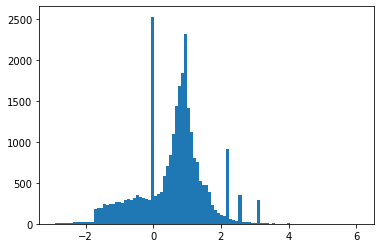

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These datasets return individual examples. Use the `.batch` method to create batches of an appropriate size for training. Before batching also remember to `.shuffle` and `.repeat` the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

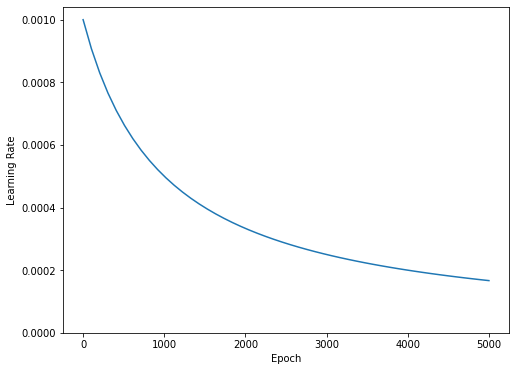

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4995,  binary_crossentropy:0.7955,  loss:0.7955,  val_accuracy:0.5140,  val_binary_crossentropy:0.7285,  val_loss:0.7285,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 100, accuracy:0.5907,  binary_crossentropy:0.6291,  loss:0.6291,  val_accuracy:0.5790,  val_binary_crossentropy:0.6281,  val_loss:0.6281,  
..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..
Epoch: 200, accuracy:0.6161,  binary_crossentropy:0.6164,  loss:0.6164,  val_accuracy:0.5890,  val_binary_crossentropy:0.6189,  val_loss:0.6189,  
.

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...


Epoch: 300, accuracy:0.6319,  binary_crossentropy:0.6059,  loss:0.6059,  val_accuracy:0.6250,  val_binary_crossentropy:0.6072,  val_loss:0.6072,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 400, accuracy:0.6423,  binary_crossentropy:0.5992,  loss:0.5992,  val_accuracy:0.6240,  val_binary_crossentropy:0.6027,  val_loss:0.6027,  
..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..
Epoch: 500, accuracy:0.6610,  binary_crossentropy:0.5921,  loss:0.5921,  val_accuracy:0.6210,  val_binary_crossentropy:0.6000,  val_loss:0.6000,  
.

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

....

...

...

...

...

...

...

...

...

...

...


Epoch: 600, accuracy:0.6651,  binary_crossentropy:0.5882,  loss:0.5882,  val_accuracy:0.6330,  val_binary_crossentropy:0.5962,  val_loss:0.5962,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

...

..
Epoch: 700, accuracy:0.6654,  binary_crossentropy:0.5858,  loss:0.5858,  val_accuracy:0.6630,  val_binary_crossentropy:0.5916,  val_loss:0.5916,  
.

...

...

...

..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 800, accuracy:0.6681,  binary_crossentropy:0.5829,  loss:0.5829,  val_accuracy:0.6620,  val_binary_crossentropy:0.5911,  val_loss:0.5911,  
..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..
Epoch: 900, accuracy:0.6735,  binary_crossentropy:0.5813,  loss:0.5813,  val_accuracy:0.6580,  val_binary_crossentropy:0.5906,  val_loss:0.5906,  
.

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...


Epoch: 1000, accuracy:0.6744,  binary_crossentropy:0.5794,  loss:0.5794,  val_accuracy:0.6590,  val_binary_crossentropy:0.5896,  val_loss:0.5896,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

...

...

...

...

..
Epoch: 1100, accuracy:0.6791,  binary_crossentropy:0.5782,  loss:0.5782,  val_accuracy:0.6470,  val_binary_crossentropy:0.5913,  val_loss:0.5913,  
.

...

...

...

...

...

...

...

...

...

...

...

..

..

...

...

..

..

...

...

...

...

..

..

...

...

...

...

...

...

...

...

...

...

...

...


Epoch: 1200, accuracy:0.6770,  binary_crossentropy:0.5764,  loss:0.5764,  val_accuracy:0.6690,  val_binary_crossentropy:0.5879,  val_loss:0.5879,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 1300, accuracy:0.6773,  binary_crossentropy:0.5759,  loss:0.5759,  val_accuracy:0.6760,  val_binary_crossentropy:0.5873,  val_loss:0.5873,  
..

...

...

...

...

...

...

...

...

...

..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...


Epoch: 1400, accuracy:0.6818,  binary_crossentropy:0.5743,  loss:0.5743,  val_accuracy:0.6610,  val_binary_crossentropy:0.5879,  val_loss:0.5879,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 1500, accuracy:0.6835,  binary_crossentropy:0.5735,  loss:0.5735,  val_accuracy:0.6520,  val_binary_crossentropy:0.5916,  val_loss:0.5916,  
..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..
Epoch: 1600, accuracy:0.6869,  binary_crossentropy:0.5722,  loss:0.5722,  val_accuracy:0.6650,  val_binary_crossentropy:0.5881,  val_loss:0.5881,  
.

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...


Epoch: 1700, accuracy:0.6823,  binary_crossentropy:0.5716,  loss:0.5716,  val_accuracy:0.6710,  val_binary_crossentropy:0.5865,  val_loss:0.5865,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

Now check how the model did:

(0.5, 0.7)

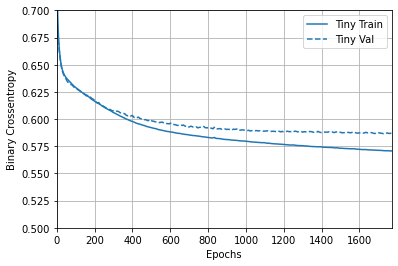

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5282,  binary_crossentropy:0.8122,  loss:0.8122,  val_accuracy:0.5050,  val_binary_crossentropy:0.7110,  val_loss:0.7110,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 100, accuracy:0.6249,  binary_crossentropy:0.6134,  loss:0.6134,  val_accuracy:0.6370,  val_binary_crossentropy:0.6107,  val_loss:0.6107,  
.

..

..

..

..

..

..

..

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

..

..

...

...

..

..

..

..

..

...

..

..

..

...

..


Epoch: 200, accuracy:0.6576,  binary_crossentropy:0.5936,  loss:0.5936,  val_accuracy:0.6490,  val_binary_crossentropy:0.5916,  val_loss:0.5916,  
...

...

...

...

...

..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..
Epoch: 300, accuracy:0.6760,  binary_crossentropy:0.5808,  loss:0.5808,  val_accuracy:0.6490,  val_binary_crossentropy:0.5890,  val_loss:0.5890,  
.

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...


Epoch: 400, accuracy:0.6842,  binary_crossentropy:0.5739,  loss:0.5739,  val_accuracy:0.6580,  val_binary_crossentropy:0.5877,  val_loss:0.5877,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 500, accuracy:0.6919,  binary_crossentropy:0.5694,  loss:0.5694,  val_accuracy:0.6680,  val_binary_crossentropy:0.5875,  val_loss:0.5875,  
..

...

...

...

...

...

...

...

...

...

...

...

...

...

..

### Medium model

Now try 3 hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4730,  binary_crossentropy:0.7116,  loss:0.7116,  val_accuracy:0.4760,  val_binary_crossentropy:0.6788,  val_loss:0.6788,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

..

..

..

..
Epoch: 100, accuracy:0.7094,  binary_crossentropy:0.5330,  loss:0.5330,  val_accuracy:0.6720,  val_binary_crossentropy:0.5980,  val_loss:0.5980,  
.

..

...

...

...

..

..

...

..

...

...

...

...

..

..

..

..

...

...

...

...

...

...

...

...

...

..

...

...

...

...

...

...

...

...

...

...


Epoch: 200, accuracy:0.7866,  binary_crossentropy:0.4317,  loss:0.4317,  val_accuracy:0.6510,  val_binary_crossentropy:0.6785,  val_loss:0.6785,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

..

...

...

...

...

### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5132,  binary_crossentropy:0.7929,  loss:0.7929,  val_accuracy:0.4760,  val_binary_crossentropy:0.6944,  val_loss:0.6944,  
...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0021,  loss:0.0021,  val_accuracy:0.6700,  val_binary_crossentropy:1.7392,  val_loss:1.7392,  
..

...

...

...

...

...

..

...

...

..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

.
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6700,  val_binary_crossentropy:2.3772,  val_loss:2.3772,  
..

...

...

...

...

...

..

..

..

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

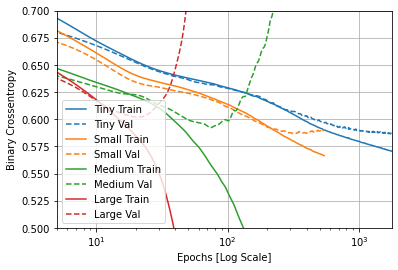

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpxq_r4ocw/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5123,  binary_crossentropy:0.8077,  loss:2.3264,  val_accuracy:0.4860,  val_binary_crossentropy:0.6764,  val_loss:2.1163,  
...

...

...

...

...

...

...

...

...

...

...

...

..

...

...

...

..

...

..

...

..

...

..

..

..

..

...

..

...

...

...

...

...

...

...

...

.
Epoch: 100, accuracy:0.6615,  binary_crossentropy:0.5958,  loss:0.6192,  val_accuracy:0.6500,  val_binary_crossentropy:0.5956,  val_loss:0.6191,  
..

...

...

...

...

...

..

...

...

...

...

...

...

...

...

...

..

..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..
Epoch: 200, accuracy:0.6715,  binary_crossentropy:0.5825,  loss:0.6049,  val_accuracy:0.6760,  val_binary_crossentropy:0.5766,  val_loss:0.5991,  
.

...

...

...

...

...

...

..

...

...

...

...

...

...

...

..

..

..

...

..

...

...

...

...

...

...

..

..

..

...

...

...

...

...

...

...

..
Epoch: 300, accuracy:0.6760,  binary_crossentropy:0.5783,  loss:0.6018,  val_accuracy:0.6900,  val_binary_crossentropy:0.5792,  val_loss:0.6027,  
.

..

..

...

..

...

...

...

..

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

..

...

...

..

...

..

...

...

..
Epoch: 400, accuracy:0.6869,  binary_crossentropy:0.5723,  loss:0.5963,  val_accuracy:0.6990,  val_binary_crossentropy:0.5761,  val_loss:0.6012,  
.

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

..

..

...

...

...

...

..

...

...

..

...

...

...

...

...

...

...

...

.
Epoch: 500, accuracy:0.6877,  binary_crossentropy:0.5656,  loss:0.5900,  val_accuracy:0.6850,  val_binary_crossentropy:0.5768,  val_loss:0.6012,  
..

...

...

...

...

...

...

...

..

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

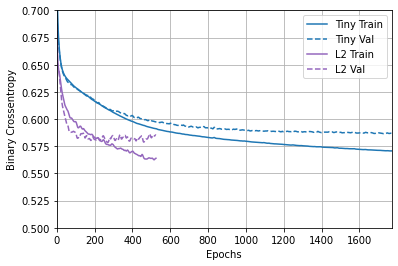

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As you can see, the `"L2"` regularized model is now much more competitive with the the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization.

**First:** if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              


Epoch: 0, accuracy:0.5072,  binary_crossentropy:0.7935,  loss:0.7935,  val_accuracy:0.5700,  val_binary_crossentropy:0.6825,  val_loss:0.6825,  
..

..

...

...

...

...

...

...

...

...

...

...

...

...

..

..

..

...

...

...

...

...

...

...

..

..

...

...

...

...

...

...

...

...

...

..
Epoch: 100, accuracy:0.6652,  binary_crossentropy:0.5943,  loss:0.5943,  val_accuracy:0.6690,  val_binary_crossentropy:0.5810,  val_loss:0.5810,  
.

...

..

...

...

...

...

..

..

...

...

...

..

...

...

..

...

...

...

...

...

..

..

..

..

..

...

...

...

...

...

...

...

...

...

..

..

...


Epoch: 200, accuracy:0.6849,  binary_crossentropy:0.5543,  loss:0.5543,  val_accuracy:0.6800,  val_binary_crossentropy:0.5859,  val_loss:0.5859,  
...

...

..

...

..

..

..

...

..

...

..

...

...

..

...

..

..

..

...

...

...

...

..

...

..

..

..

..

...

..

..

..

..

..

...

..

...

...

...

...

.
Epoch: 300, accuracy:0.7211,  binary_crossentropy:0.5089,  loss:0.5089,  val_accuracy:0.6790,  val_binary_crossentropy:0.6065,  val_loss:0.6065,  
.

..

..

..

..

....

..

..

..

..

..

..

.

(0.5, 0.7)

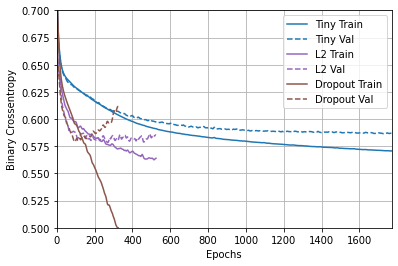

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              


Epoch: 0, accuracy:0.5074,  binary_crossentropy:0.8059,  loss:0.9643,  val_accuracy:0.4720,  val_binary_crossentropy:0.6770,  val_loss:0.8347,  
..

..

..

..

..

..

...

...

...

...

...

...

...

...

...

...

...

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

...

...

...

...

...

..

...

..

..


Epoch: 100, accuracy:0.6461,  binary_crossentropy:0.6069,  loss:0.6370,  val_accuracy:0.6610,  val_binary_crossentropy:0.5833,  val_loss:0.6132,  
..

..

..

..

...

...

...

...

...

..

..

..

..

..

..

...

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

...

...

...

...

...

...

..

...

..
Epoch: 200, accuracy:0.6613,  binary_crossentropy:0.5935,  loss:0.6191,  val_accuracy:0.6800,  val_binary_crossentropy:0.5722,  val_loss:0.5978,  
.

...

..

...

...

..

...

..

..

..

...

...

...

...

...

...

..

..

..

..

..

..

..

..

...

...

..

...

...

...

...

..

..

...

...

...

...

...

...

.
Epoch: 300, accuracy:0.6704,  binary_crossentropy:0.5882,  loss:0.6158,  val_accuracy:0.6720,  val_binary_crossentropy:0.5614,  val_loss:0.5889,  
..

...

...

...

..

..

..

...

...

...

...

...

...

..

..

...

...

...

...

...

...

..

...

...

...

...

...

...

...

...

..

..

..

...

..

...

..

.
Epoch: 400, accuracy:0.6715,  binary_crossentropy:0.5796,  loss:0.6090,  val_accuracy:0.6930,  val_binary_crossentropy:0.5630,  val_loss:0.5923,  
.

...

...

..

...

..

..

..

...

...

..

..

..

..

..

..

...

...

..

...

...

...

...

...

...

..

..

..

..

..

..

..

..

...

...

...

...

...

...

..

..


Epoch: 500, accuracy:0.6768,  binary_crossentropy:0.5732,  loss:0.6043,  val_accuracy:0.6850,  val_binary_crossentropy:0.5603,  val_loss:0.5915,  
..

..

..

...

...

...

...

...

...

...

...

...

..

..

..

..

..

..

..

...

..

..

..

..

..

...

...

...

...

...

...

..

..

..

..

..

..

...

..

..

..

.
Epoch: 600, accuracy:0.6794,  binary_crossentropy:0.5709,  loss:0.6034,  val_accuracy:0.6860,  val_binary_crossentropy:0.5521,  val_loss:0.5847,  
.

..

...

..

...

...

..

..

..

..

...

...

..

..

..

...

...

...

..

...

...

...

...

...

...

..

..

..

..

..

..

..

..

...

...

...

...

...

...

...


Epoch: 700, accuracy:0.6851,  binary_crossentropy:0.5633,  loss:0.5972,  val_accuracy:0.6940,  val_binary_crossentropy:0.5366,  val_loss:0.5705,  
..

..

..

..

..

...

...

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

...

...

...

..

..

..

..

..

..

..

...

.
Epoch: 800, accuracy:0.6825,  binary_crossentropy:0.5624,  loss:0.5976,  val_accuracy:0.7000,  val_binary_crossentropy:0.5465,  val_loss:0.5816,  
..

..

..

...

..

..

..

..

..

..

..

..

..

..

...

..

..

..

..

..

..

..

...

...

...

...

...

..

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

...

...


Epoch: 900, accuracy:0.6931,  binary_crossentropy:0.5578,  loss:0.5940,  val_accuracy:0.6970,  val_binary_crossentropy:0.5375,  val_loss:0.5737,  
.

(0.5, 0.7)

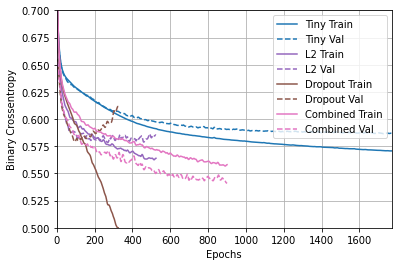

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorDoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.